# **DATATHON 2023: NTT-DATA CHALLENGE**

## **Requirements**:

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## **Main Program**

Read dataset

In [3]:
df = pd.read_excel('../assets/consumo_material_clean.xlsx')
df.head()

CODIGO FECHAPEDIDO      NUMERO REFERENCIA  CANTIDADCOMPRA  \
0  E99808    01/01/23  1595724/23   178567.1              60   
1  B41691    01/02/16    72714/16     400403              40   
2  E64543    01/02/16    71961/16     403770              20   
3  E65007    01/02/16    72773/16      20415             100   
4  E64911    01/02/17    86159/17      20701             300   

   UNIDADESCONSUMOCONTENIDAS      PRECIO  IMPORTELINEA    TIPOCOMPRA   ORIGEN  \
0                         10   62.590000    375.540000  Compra menor   1-2-60   
1                         10  102.803729    411.214916  Compra menor   0-10-1   
2                          5   12.100000     48.400000  Compra menor  0-4-111   
3                         50  215.325000    430.650000      Concurso   0-10-1   
4                        300  792.000000    792.000000      Concurso    0-6-1   

           TGL                                           PRODUCTO  
0     TRANSITO        APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-3  
1  ALMACENABLE  SOLUCION P/ LIMPIEZA Y DESCONTAMINACION DE HER...  
2     TRANSITO                  APOSITO DE HIDROFIBRA  / CINTA-18  
3  ALMACENABLE           APOSITO DE ESPUMA POLIURETANO / SACRO-11  
4  ALMACENABLE                        APOSITO C/ CARBON Y PLATA-6

Some preprocessing

In [4]:
# Drop rows with NaN values
df = df.dropna()

# Split "ORIGEN" into "REGION", "HOSPITAL" and "DEPARTAMENTO"
df['ORIGEN'] = df['ORIGEN'].str.replace('--', '-')
df[['REGION', 'HOSPITAL', 'DEPARTAMENTO']] = df['ORIGEN'].str.split('-', expand=True)
df = df.drop(["ORIGEN"], axis=1)

# Categorical variables
categorical = ['CODIGO', 'PRODUCTO', 'NUMERO', 'REFERENCIA', 'TIPOCOMPRA', 'REGION', 'HOSPITAL', 'DEPARTAMENTO', 'TGL']
df[categorical] = df[categorical].astype('category')

# Numeric variables
numerical_int = ['CANTIDADCOMPRA', 'UNIDADESCONSUMOCONTENIDAS']
numerical_float = ['PRECIO', 'IMPORTELINEA']
df[numerical_float] = df[numerical_float].astype('float')

# Date format
df['FECHAPEDIDO'] = pd.to_datetime(df['FECHAPEDIDO'], format='%d/%m/%y')
df['MES'] = df['FECHAPEDIDO'].dt.month
df['AÑO'] = df['FECHAPEDIDO'].dt.year
df = df.drop('FECHAPEDIDO', axis=1)

# Create new variable
df['PRECIOUNIDAD'] = df['IMPORTELINEA'] / df['CANTIDADCOMPRA']

df.to_csv('../assets/preprocessed_df.csv', index=False)

df.head()

CODIGO      NUMERO REFERENCIA  CANTIDADCOMPRA  UNIDADESCONSUMOCONTENIDAS  \
0  E99808  1595724/23   178567.1              60                         10   
1  B41691    72714/16     400403              40                         10   
2  E64543    71961/16     403770              20                          5   
3  E65007    72773/16      20415             100                         50   
4  E64911    86159/17      20701             300                        300   

       PRECIO  IMPORTELINEA    TIPOCOMPRA          TGL  \
0   62.590000    375.540000  Compra menor     TRANSITO   
1  102.803729    411.214916  Compra menor  ALMACENABLE   
2   12.100000     48.400000  Compra menor     TRANSITO   
3  215.325000    430.650000      Concurso  ALMACENABLE   
4  792.000000    792.000000      Concurso  ALMACENABLE   

                                            PRODUCTO REGION HOSPITAL  \
0        APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-3      1        2   
1  SOLUCION P/ LIMPIEZA Y DESCONTAMINACION DE HER...      0       10   
2                  APOSITO DE HIDROFIBRA  / CINTA-18      0        4   
3           APOSITO DE ESPUMA POLIURETANO / SACRO-11      0       10   
4                        APOSITO C/ CARBON Y PLATA-6      0        6   

  DEPARTAMENTO  MES   AÑO  PRECIOUNIDAD  
0           60    1  2023      6.259000  
1            1    2  2016     10.280373  
2          111    2  2016      2.420000  
3            1    2  2016      4.306500  
4            1    2  2017      2.640000

In [5]:
años = df['AÑO'].unique()
meses = df['MES'].unique()
productos = df['PRODUCTO'].unique()

# Crear todas las combinaciones posibles de año, mes y producto
todas_las_combinaciones = pd.DataFrame(list(itertools.product(años, meses, productos)), columns=['AÑO', 'MES', 'PRODUCTO'])

# Agrupar por año, mes y producto y realizar las operaciones de agregación
df_agrupado = df.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'CANTIDADCOMPRA': 'sum'}).reset_index()

# Combinar el DataFrame de todas las combinaciones con el DataFrame agrupado
# Usar un merge para asegurarse de que todas las combinaciones estén presentes
resultado_final = pd.merge(todas_las_combinaciones, df_agrupado, on=['AÑO', 'MES', 'PRODUCTO'], how='left')

# Rellenar los valores faltantes con 0 (o cualquier otro valor que sea apropiado)
resultado_final['CANTIDADCOMPRA'] = resultado_final['CANTIDADCOMPRA'].fillna(0)

resultado_final.to_csv('../assets/cantidadcompra_combinations.csv', index=False)


C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\788847748.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agrupado = df.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'CANTIDADCOMPRA': 'sum'}).reset_index()


In [6]:
años = df['AÑO'].unique()
meses = df['MES'].unique()
productos = df['PRODUCTO'].unique()

# Crear todas las combinaciones posibles de año, mes y producto
todas_las_combinaciones = pd.DataFrame(list(itertools.product(años, meses, productos)), columns=['AÑO', 'MES', 'PRODUCTO'])

# Agrupar por año, mes y producto y realizar las operaciones de agregación
df_agrupado = df.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'PRECIOUNIDAD': 'mean'}).reset_index()

# Combinar el DataFrame de todas las combinaciones con el DataFrame agrupado
# Usar un merge para asegurarse de que todas las combinaciones estén presentes
resultado_final = pd.merge(todas_las_combinaciones, df_agrupado, on=['AÑO', 'MES', 'PRODUCTO'], how='left')

# Rellenar los valores faltantes con 0 (o cualquier otro valor que sea apropiado)
resultado_final['PRECIOUNIDAD'] = resultado_final['PRECIOUNIDAD'].fillna(0)

resultado_final.to_csv('../assets/preciounidad_combinations.csv', index=False)


C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\4238213395.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agrupado = df.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'PRECIOUNIDAD': 'mean'}).reset_index()


ARIMA TO PREDICT CANTIDADCOMPRA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1371.759, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1333.348, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1349.208, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1324.607, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1309.283, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1300.768, Time=0.04 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1297.862, Time=0.06 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1282.408, Time=0.27 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1277.537, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1275.581, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1273.583, T

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]
C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


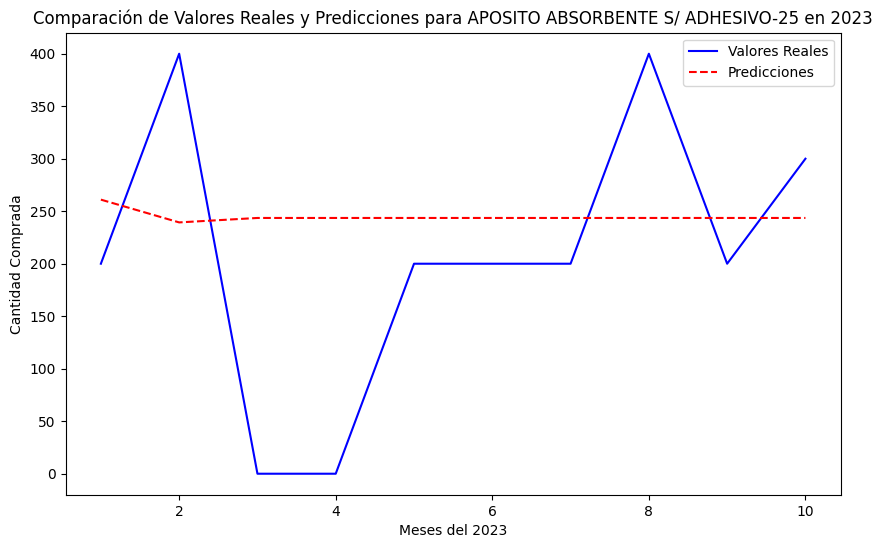

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


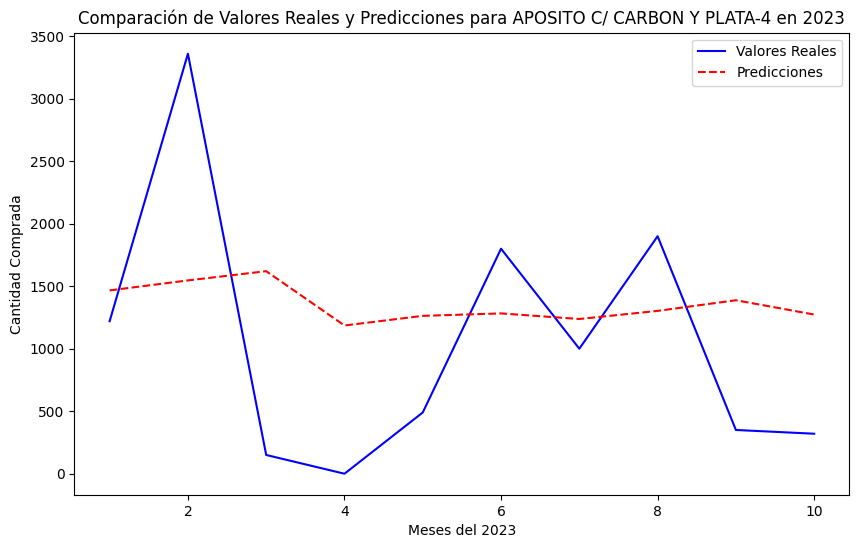

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


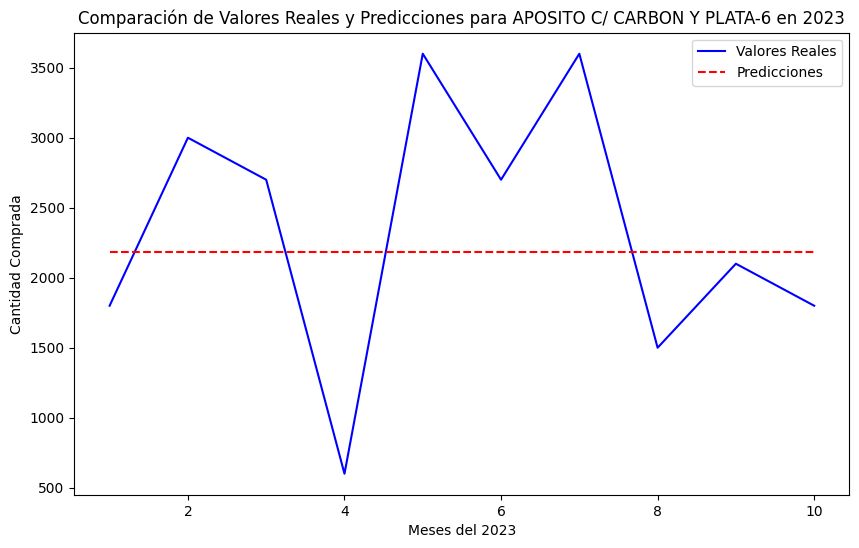

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


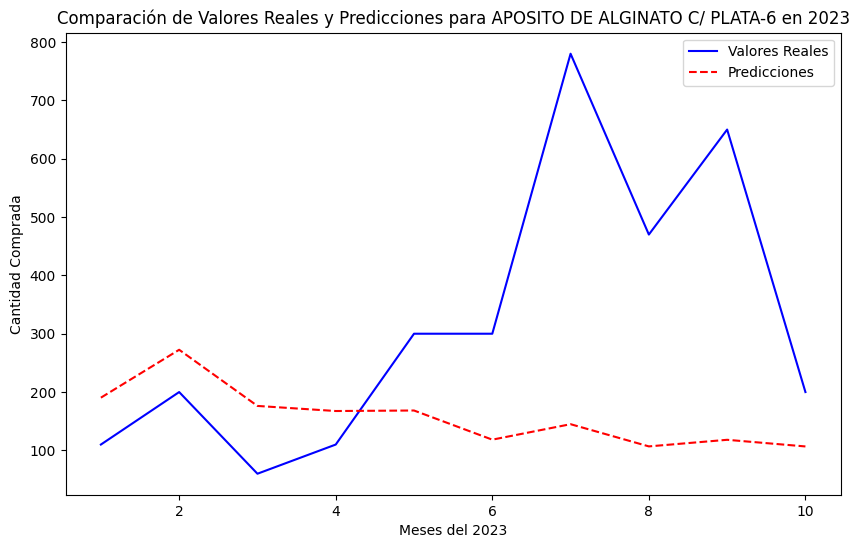

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


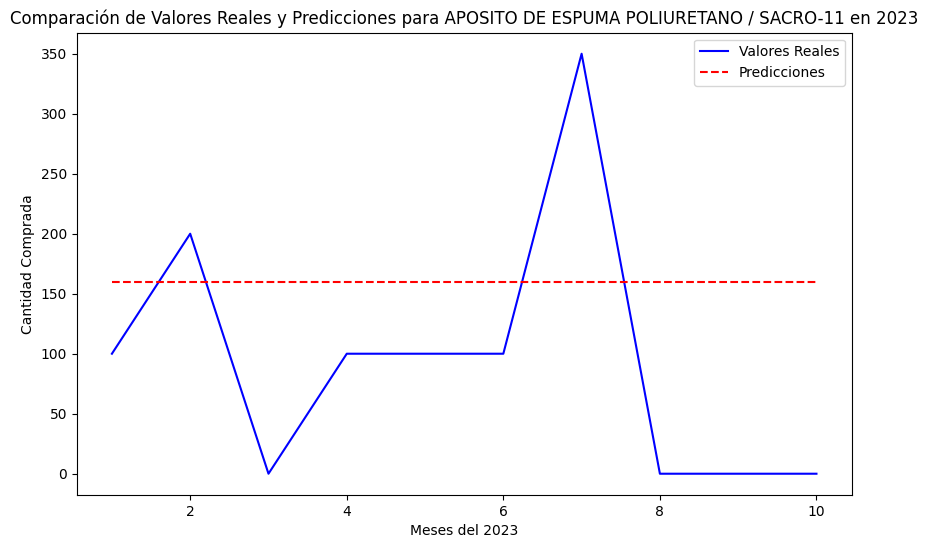

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


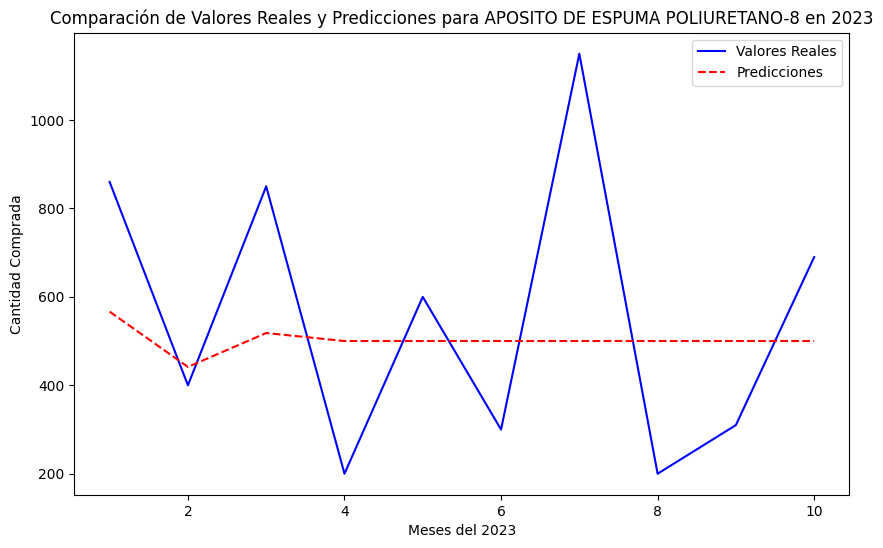

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


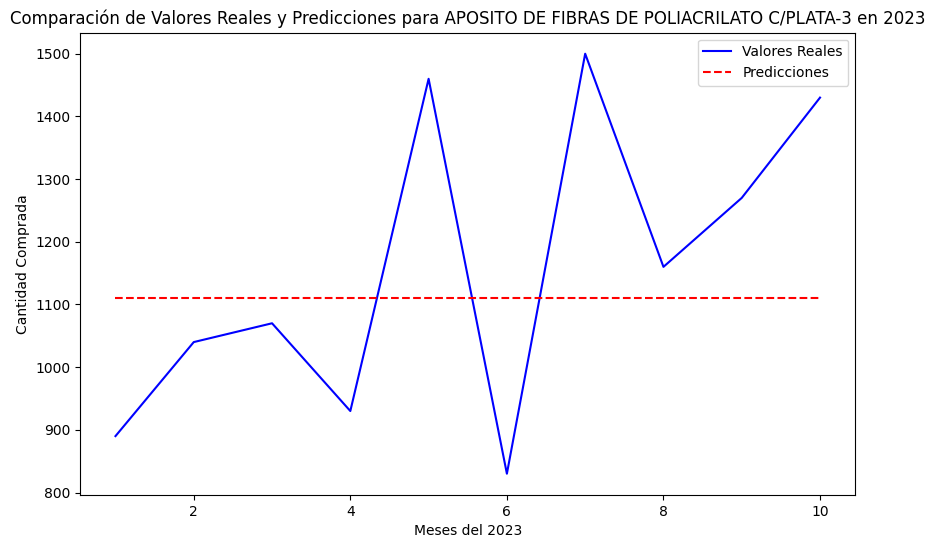

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


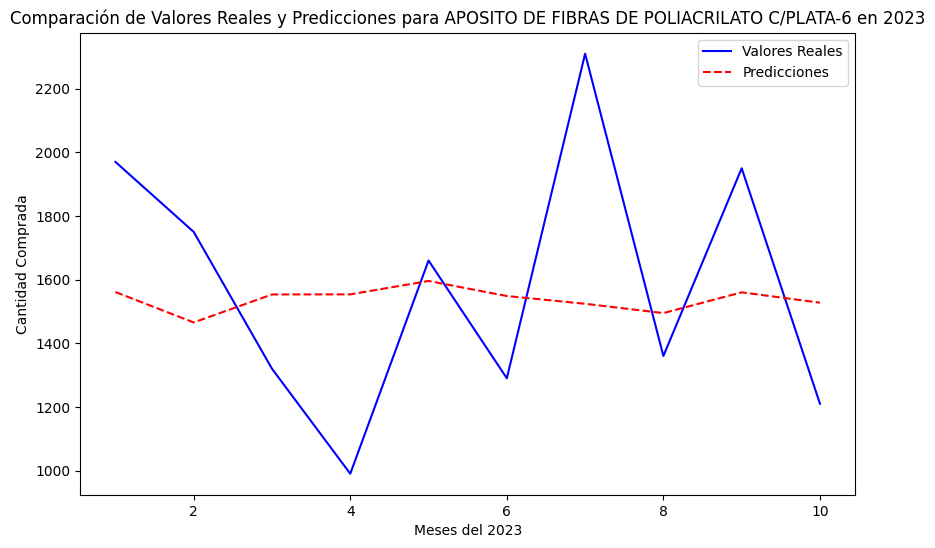

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


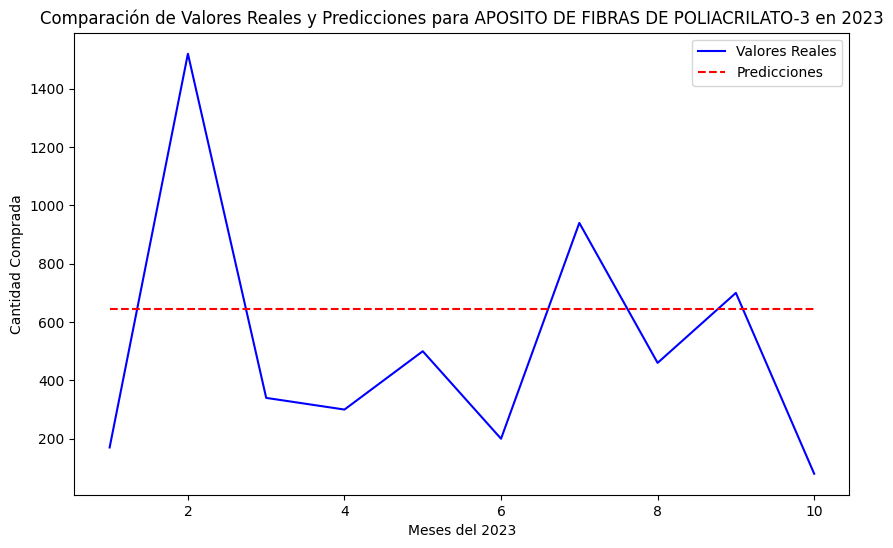

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


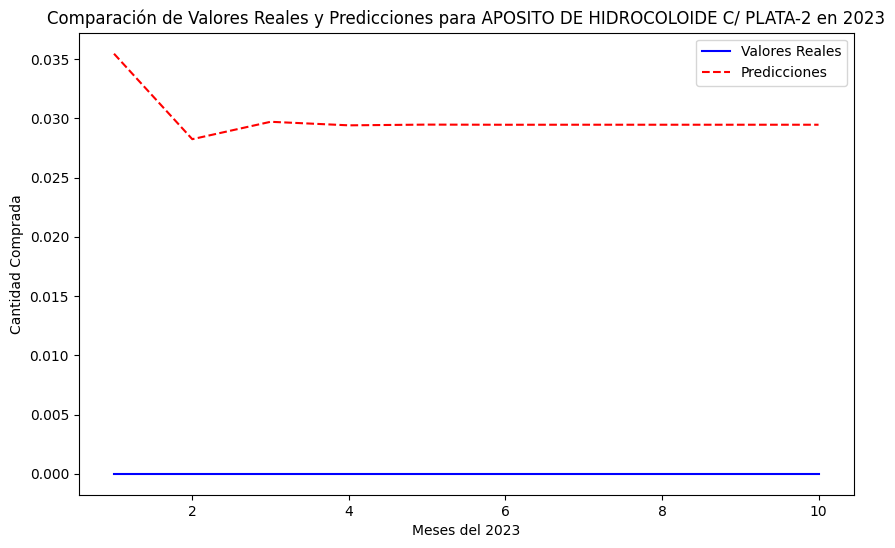

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


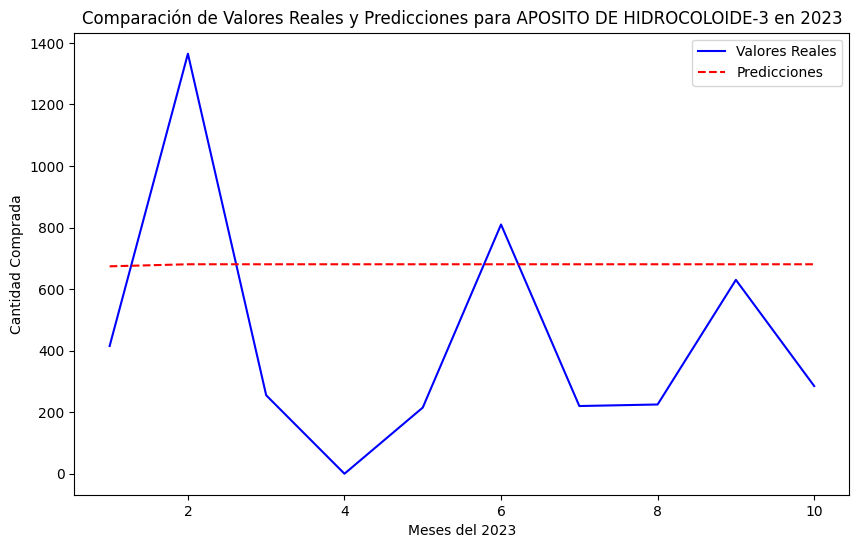

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


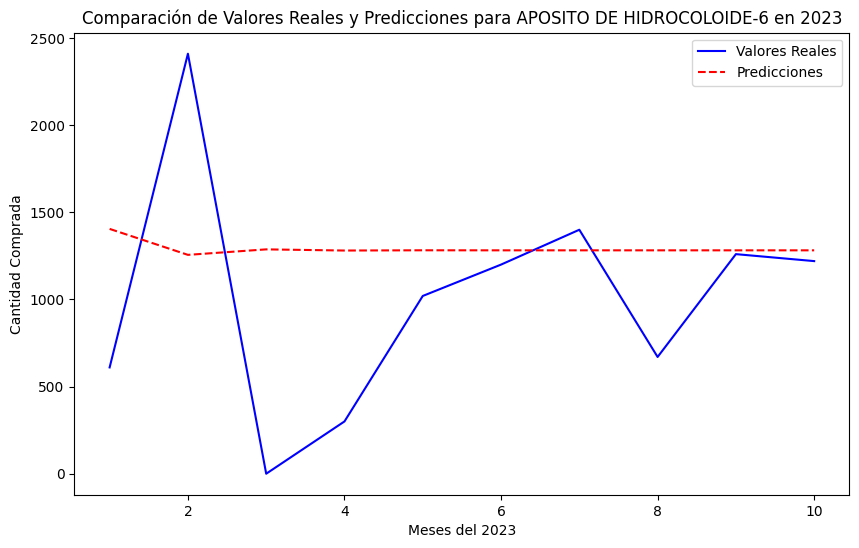

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


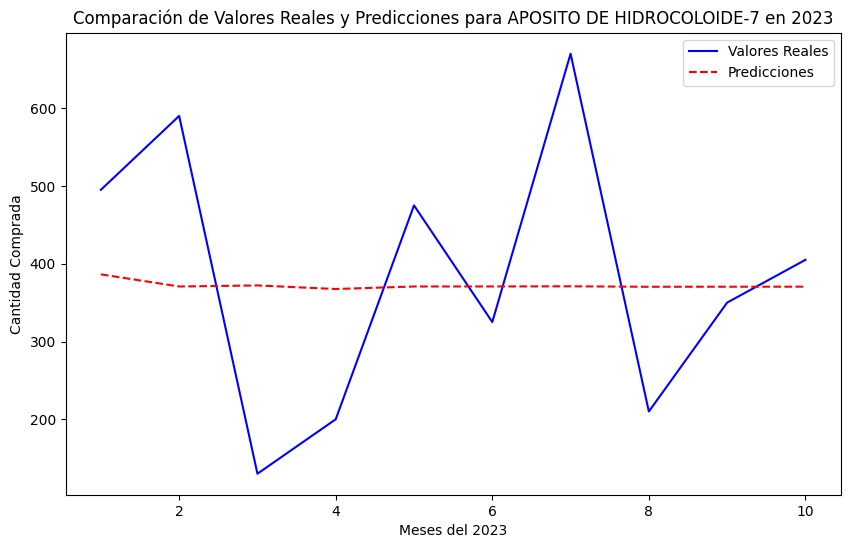

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


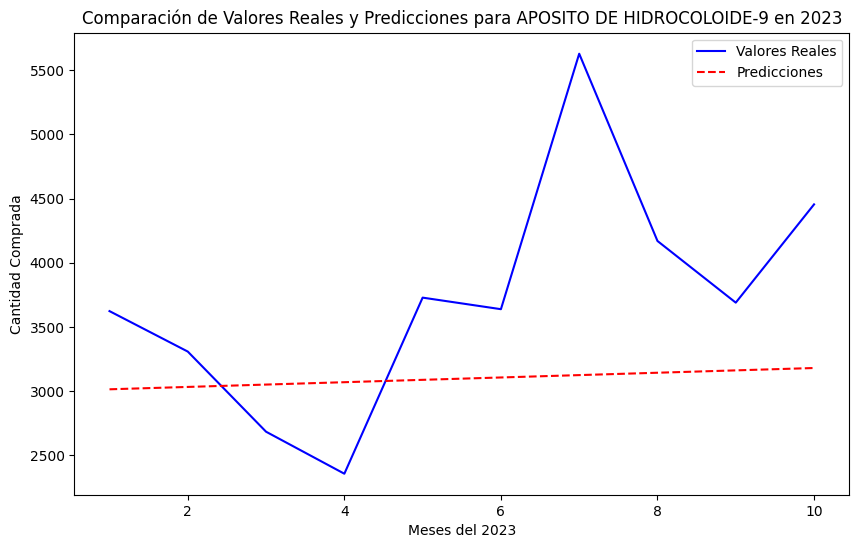

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


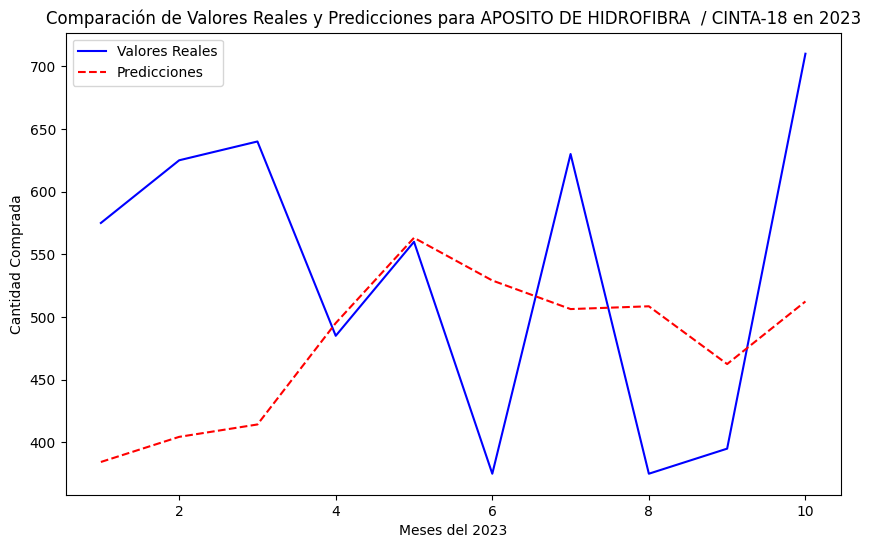

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


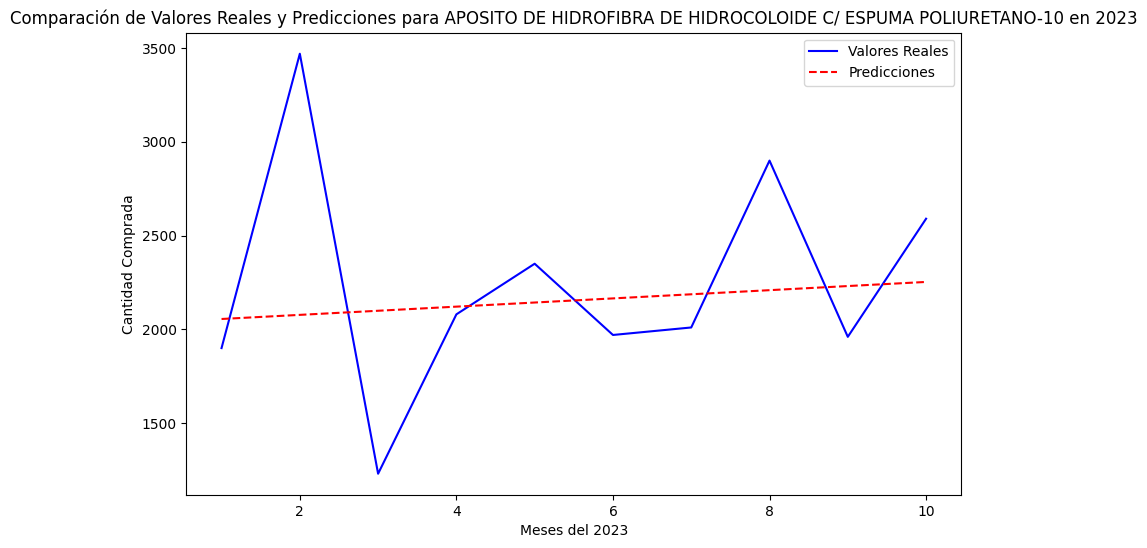

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


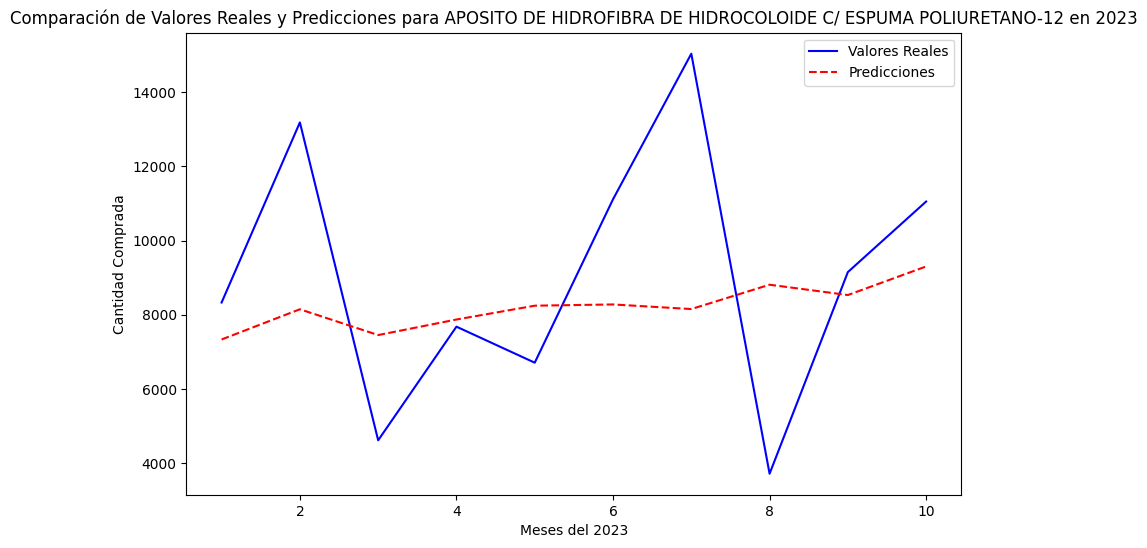

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


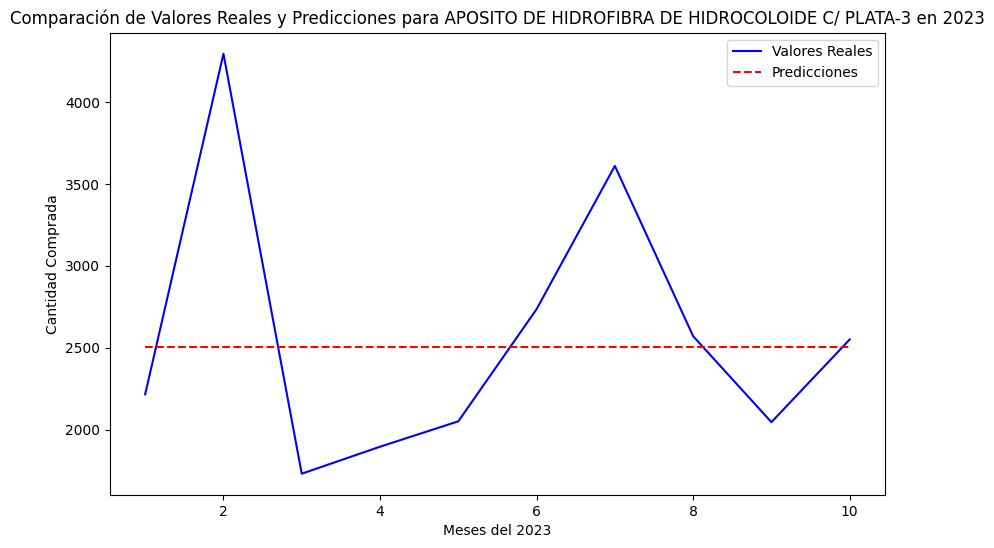

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


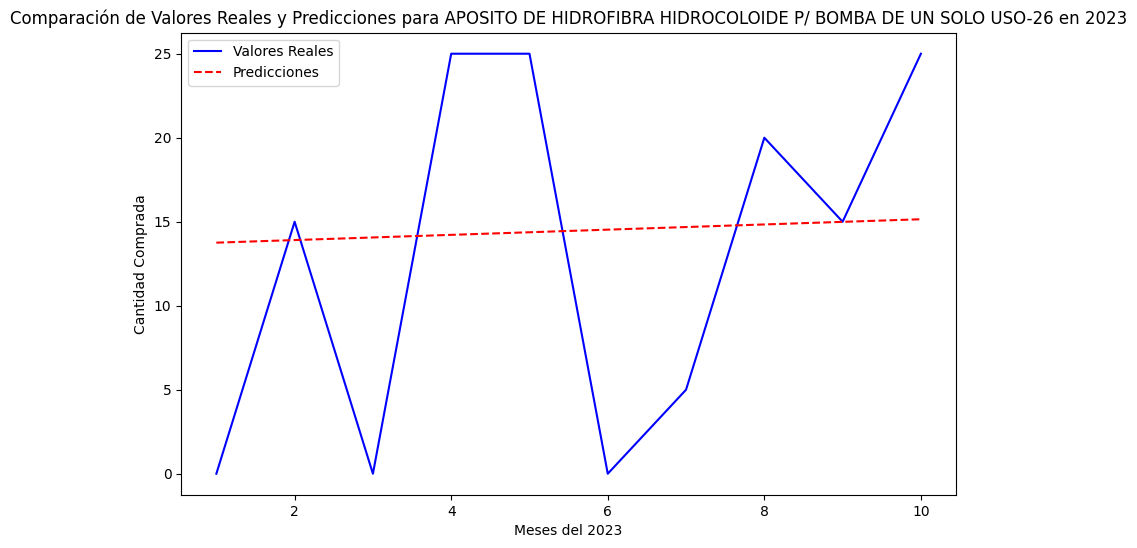

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


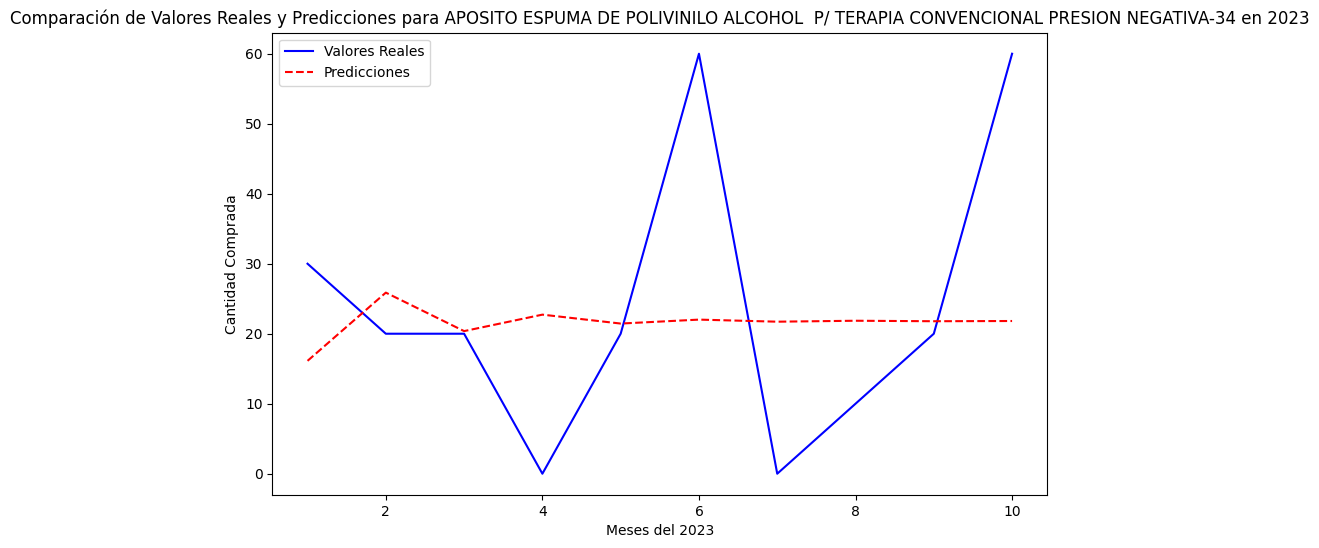

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


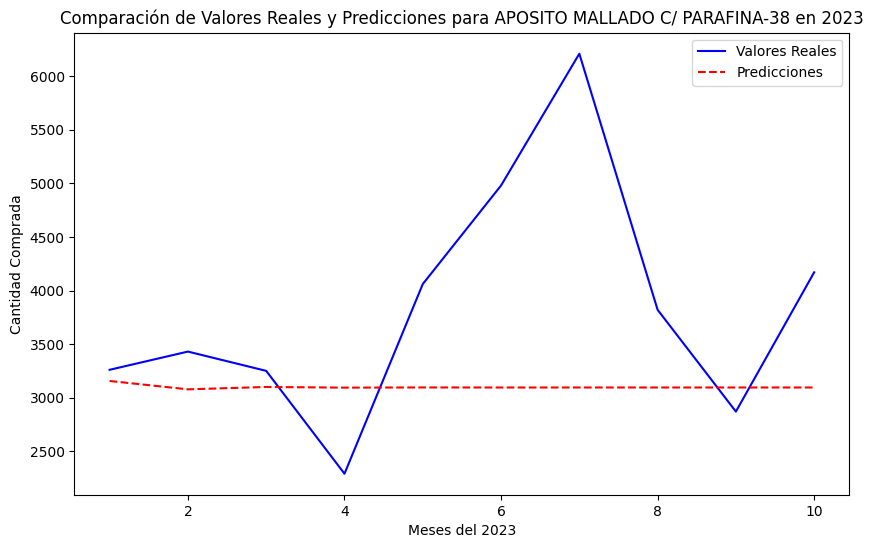

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


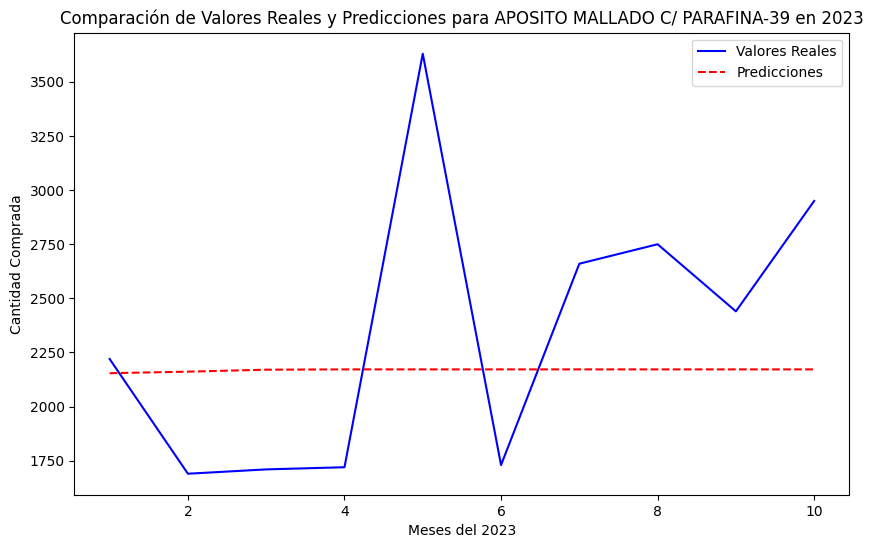

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


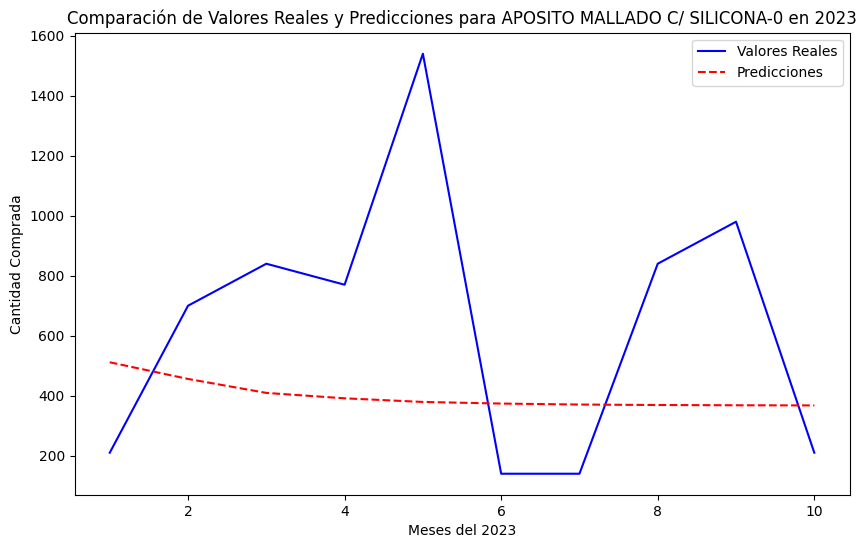

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


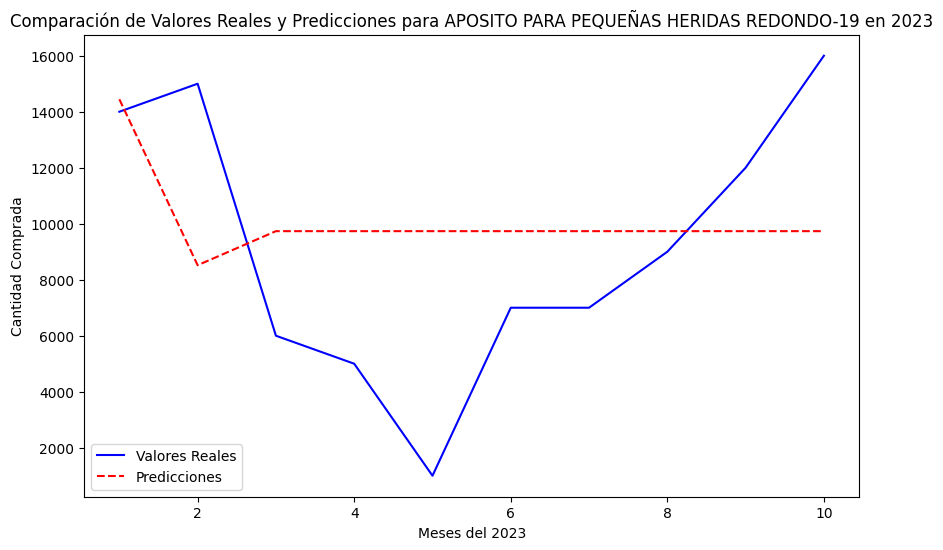

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


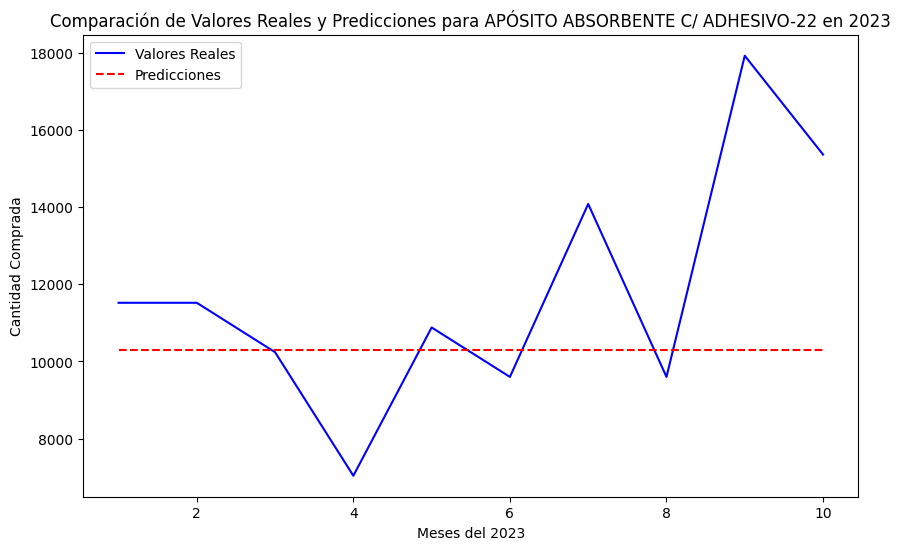

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


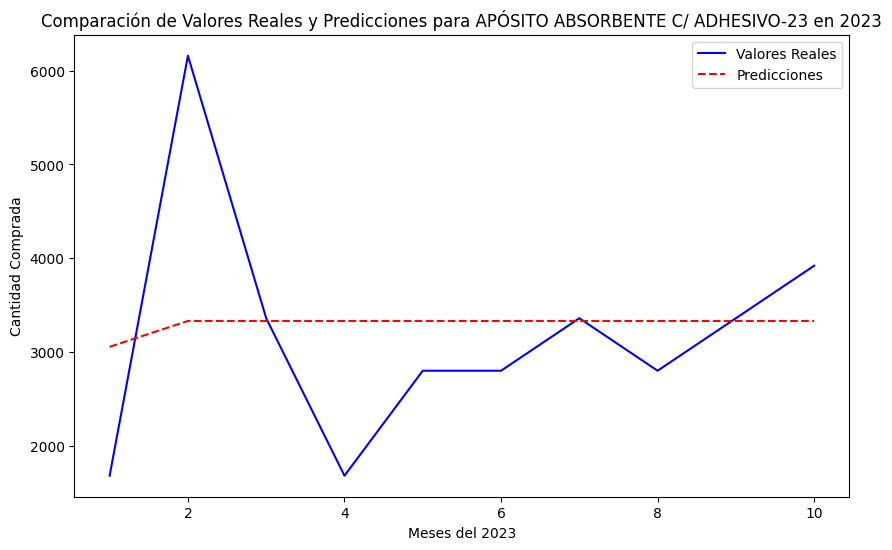

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


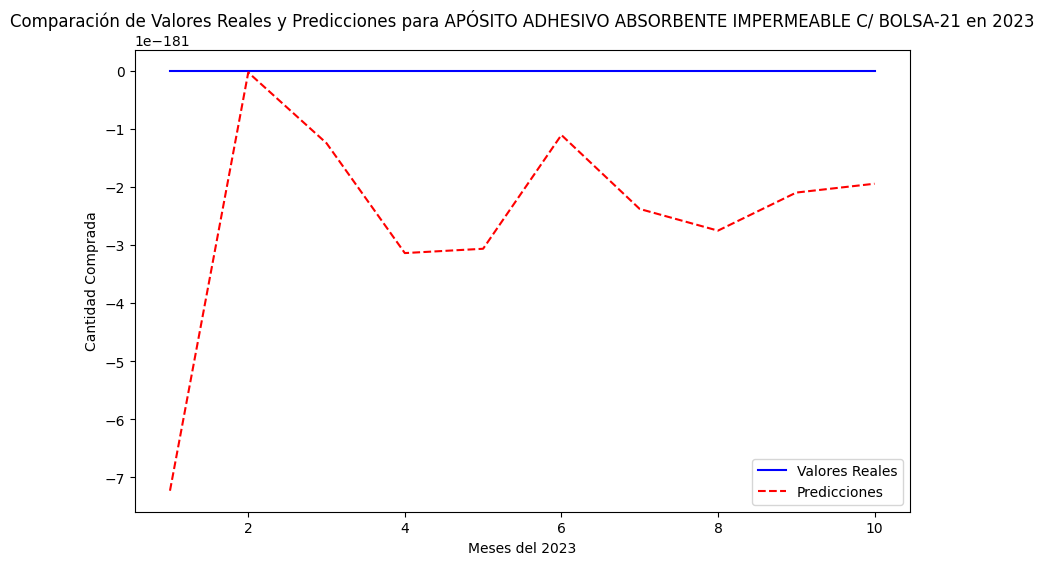

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


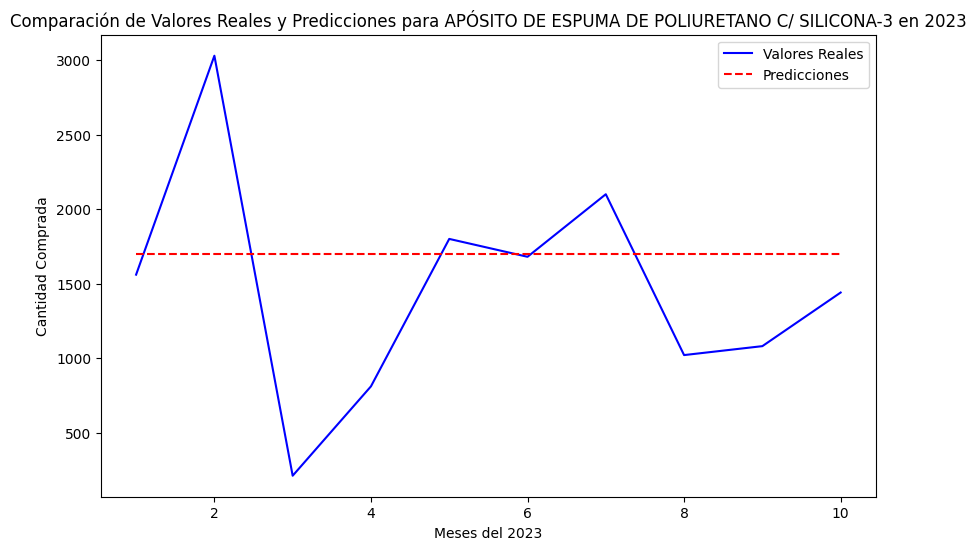

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


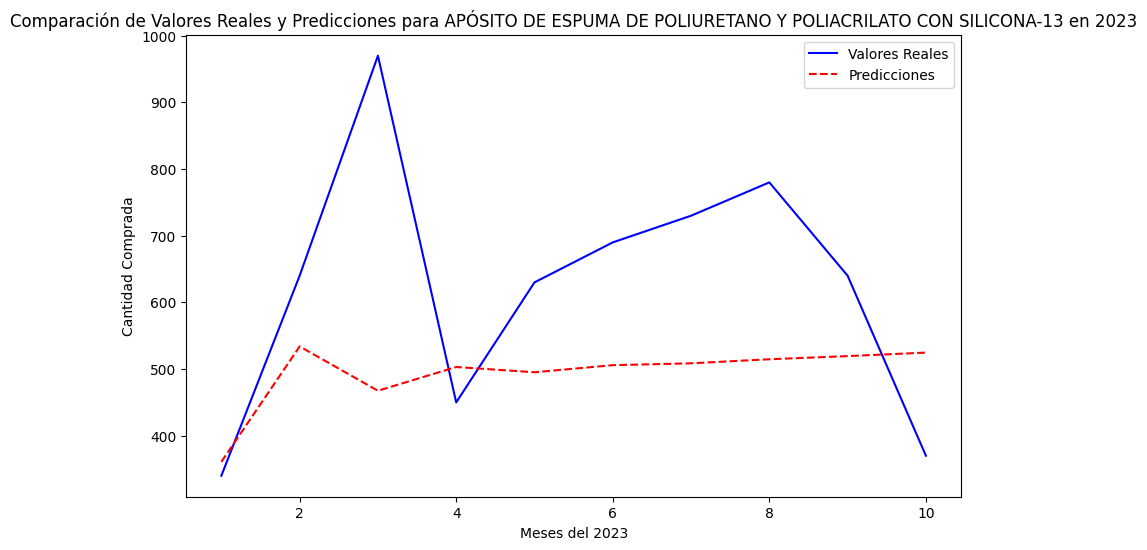

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


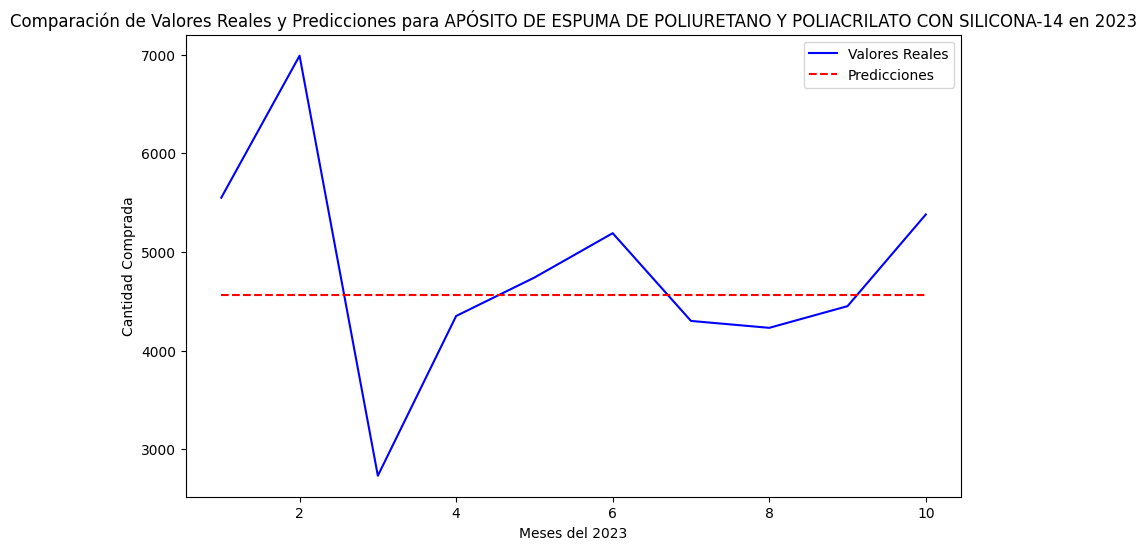

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


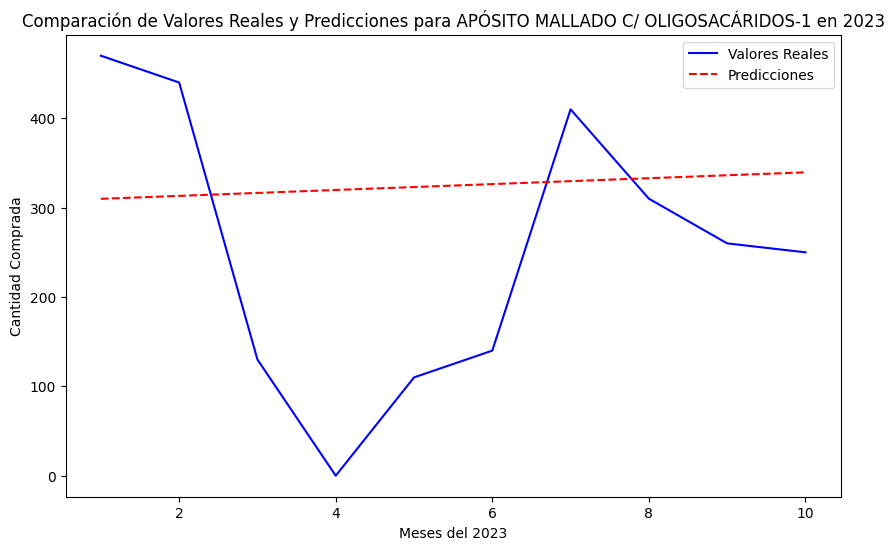

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


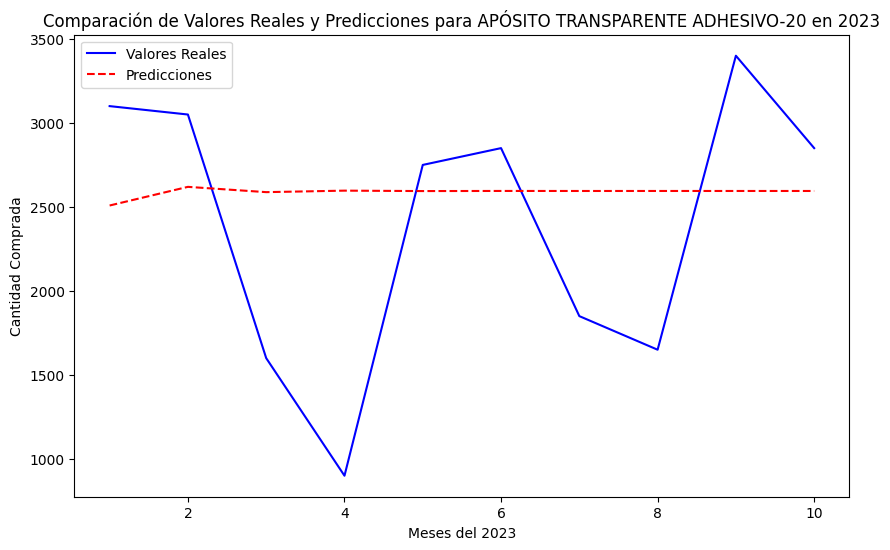

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


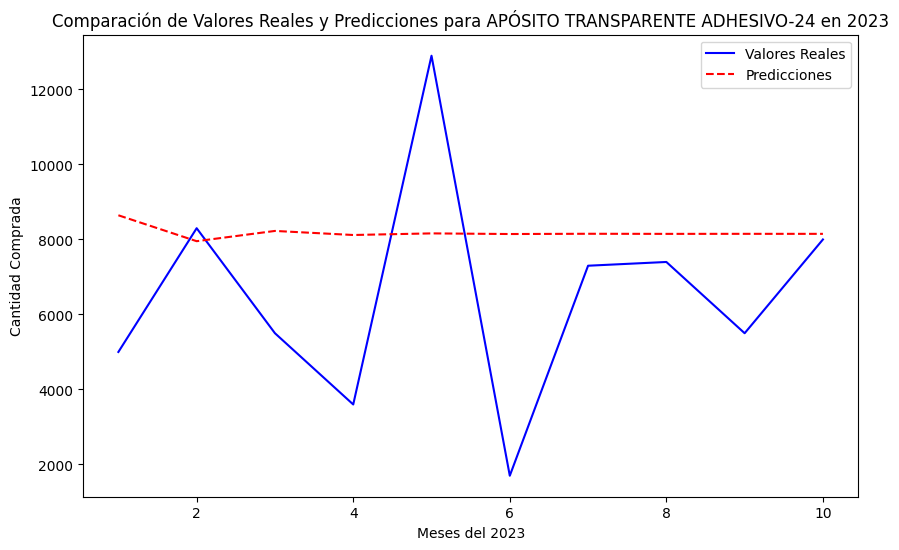

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


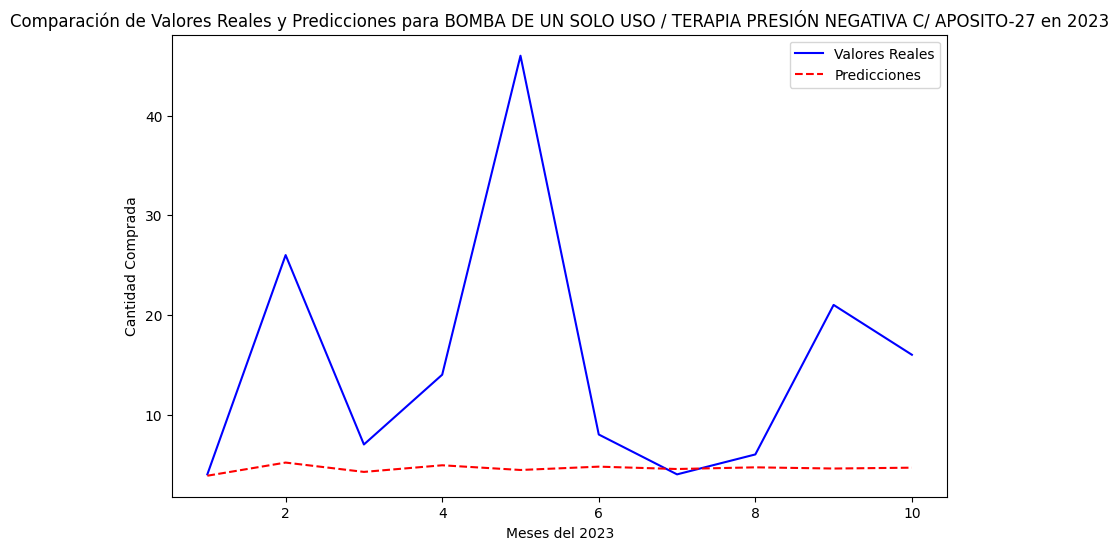

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


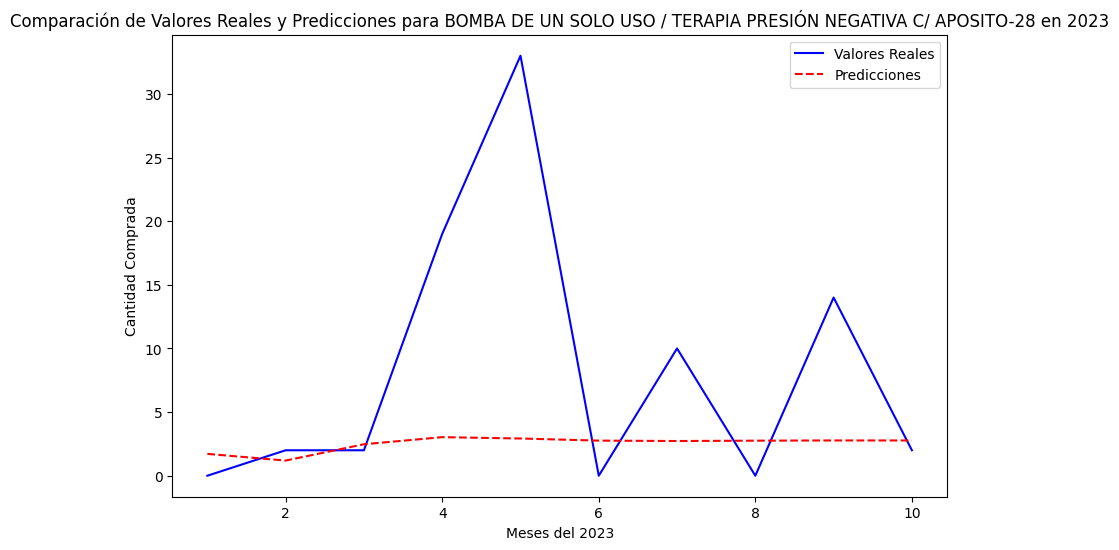

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


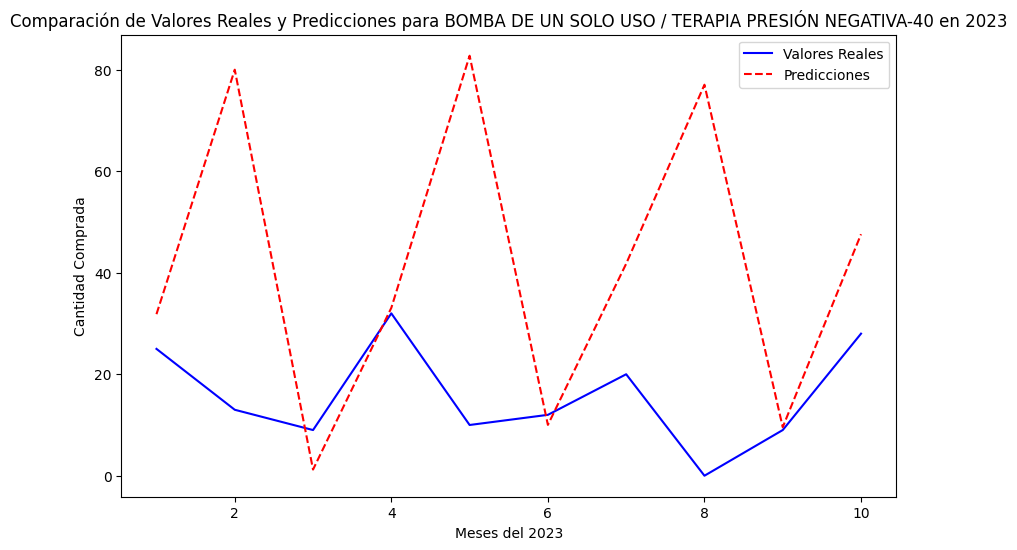

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


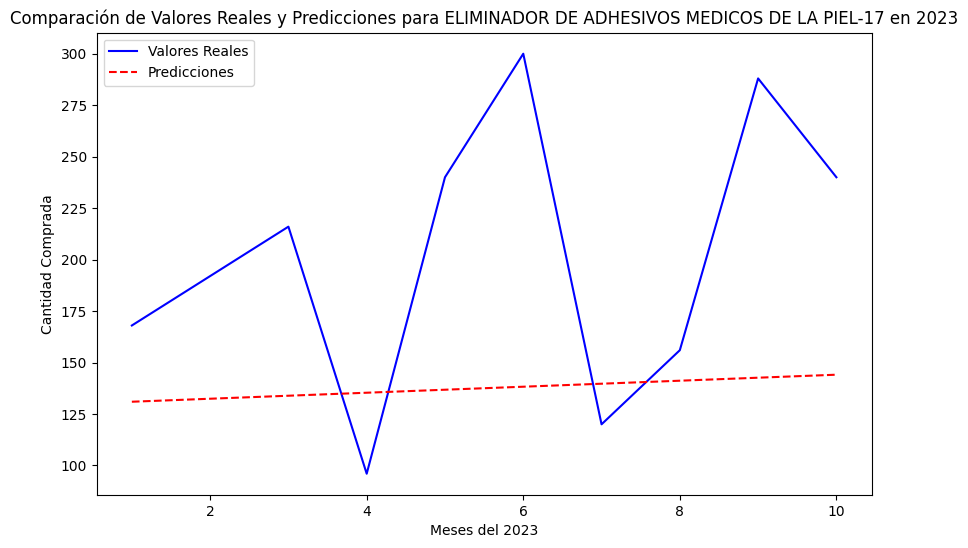

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


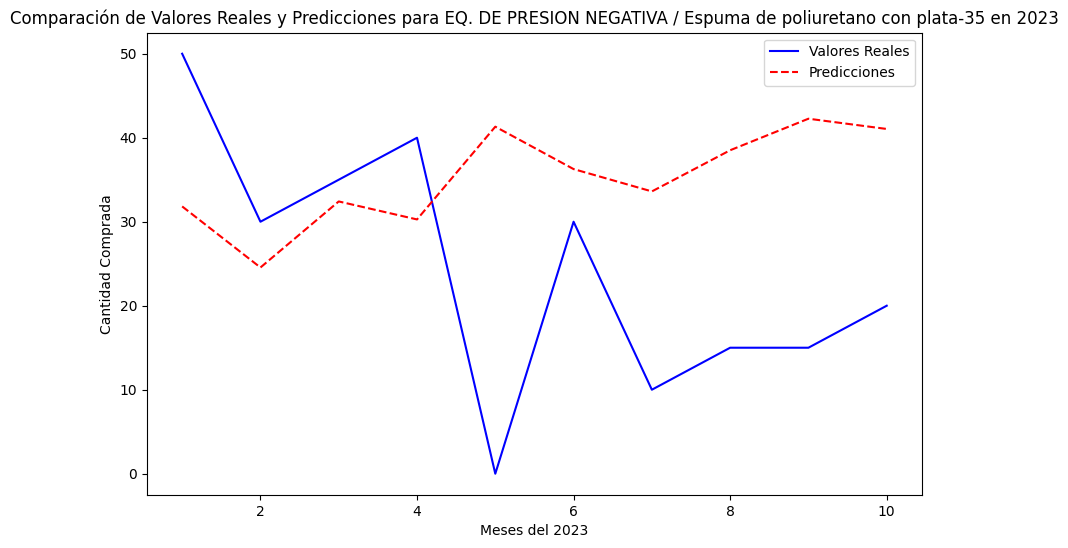

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


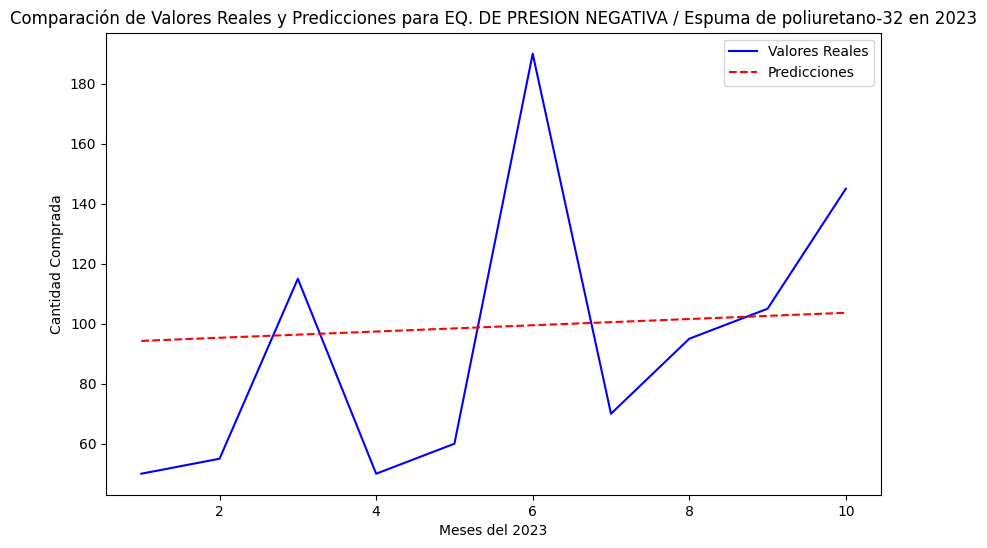

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


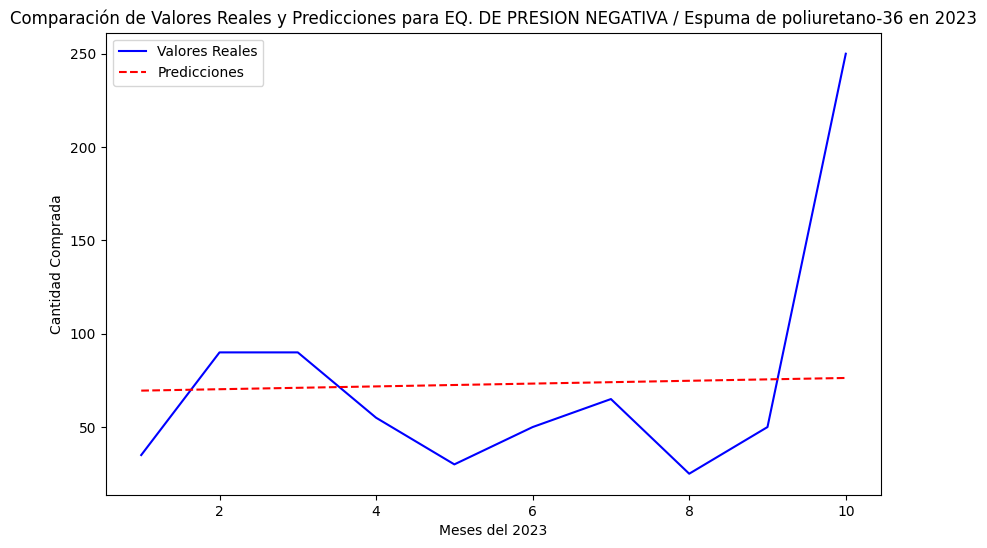

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


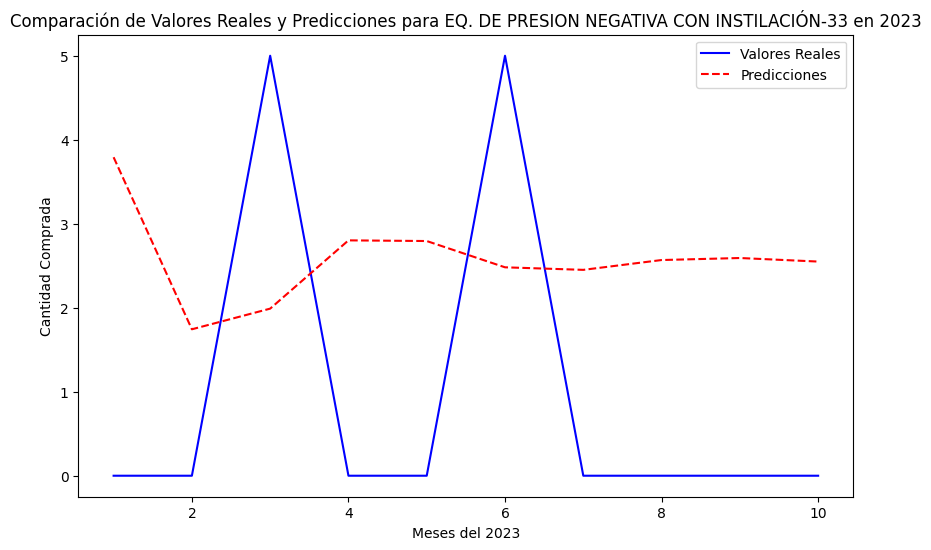

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


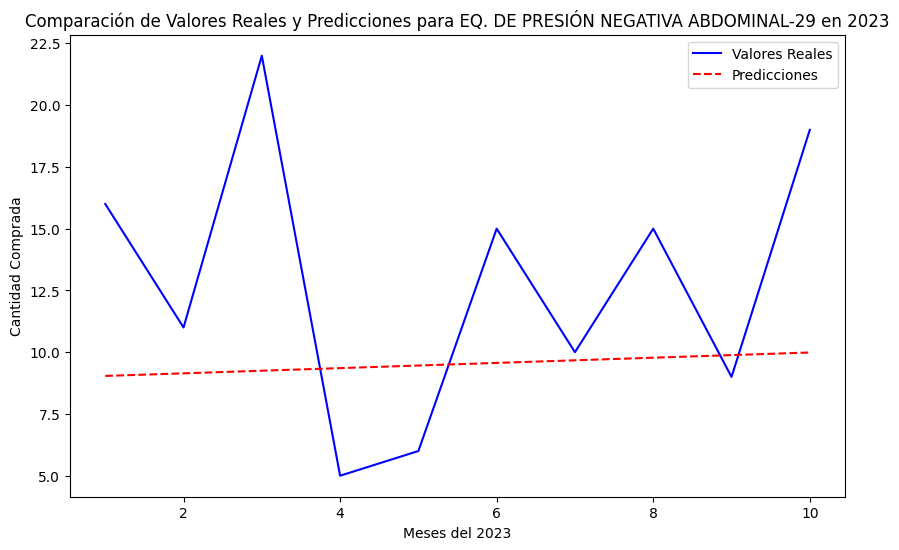

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


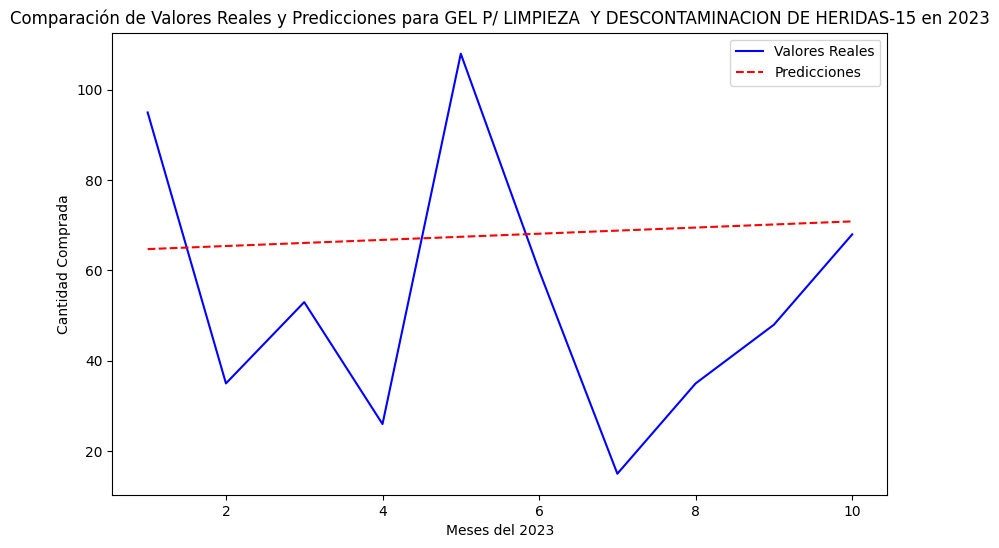

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


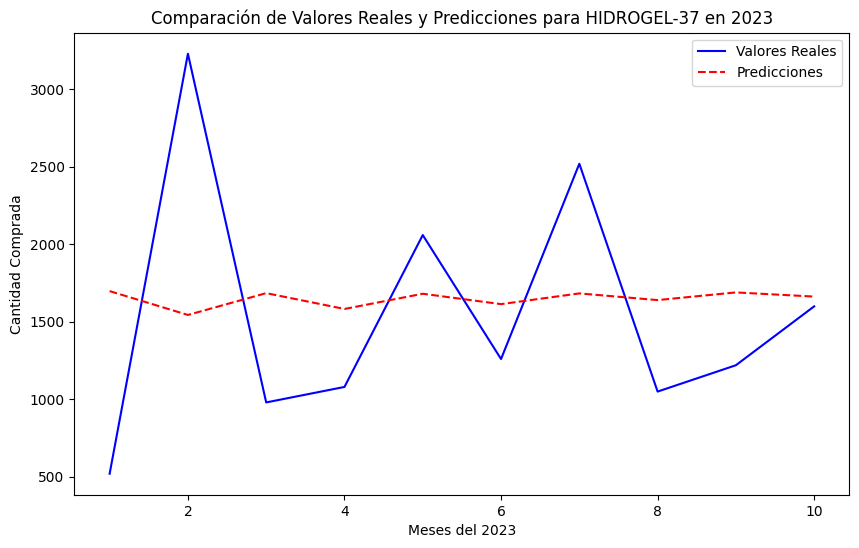

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


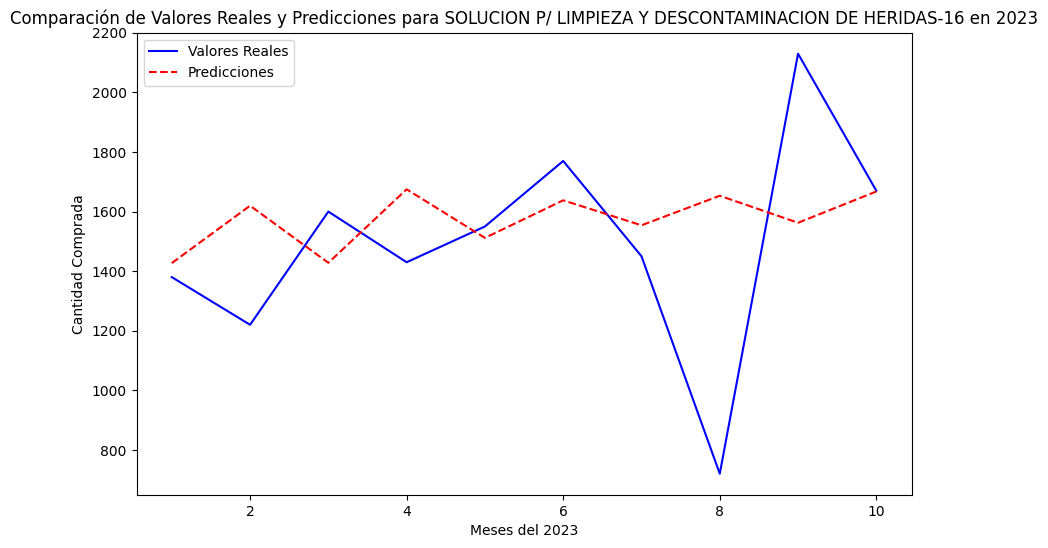

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


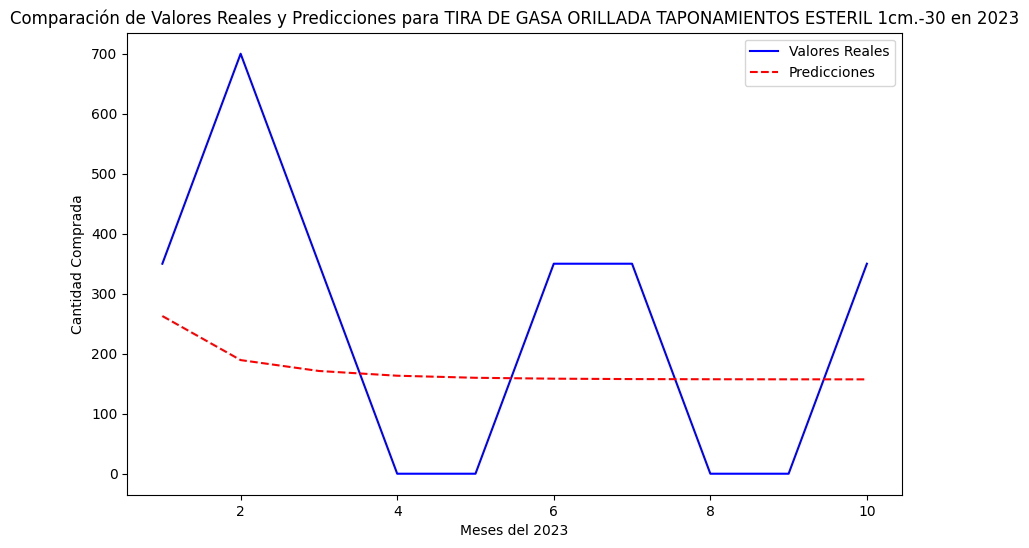

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\2998301520.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


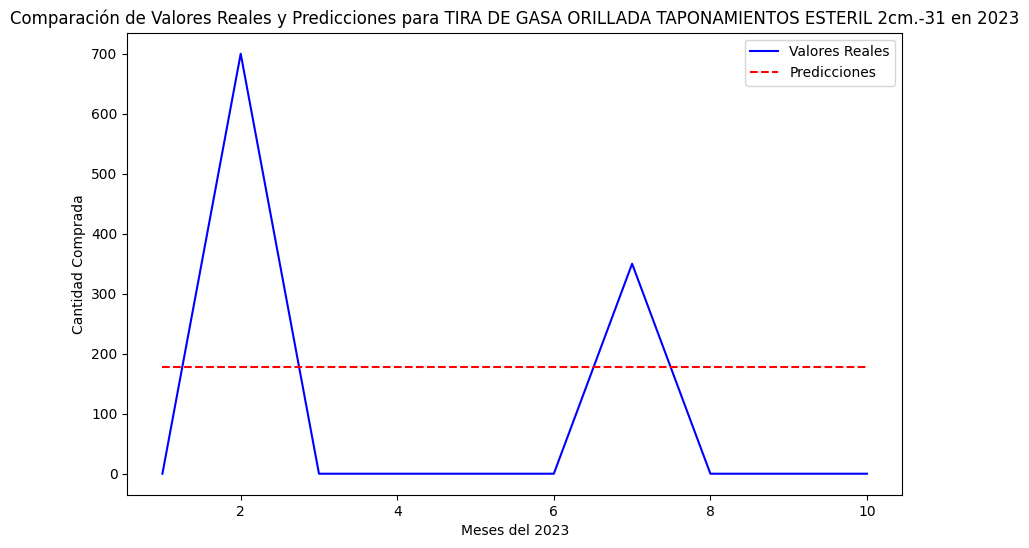

R^2 general: 0.8220204582197161


In [7]:
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# Carga de datos
data = pd.read_csv('../assets/cantidadcompra_combinations.csv')

# Agrupación de datos por producto y mes
grouped_data = data.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'CANTIDADCOMPRA': 'sum'}).reset_index()

# Inicializar un diccionario para almacenar los modelos
models = {}

# Función para verificar la estacionariedad
def check_stationarity(ts):
    return ndiffs(ts, test='adf') > 0

# Iterar sobre cada producto
for product_name in grouped_data['PRODUCTO'].unique():
    product_data = grouped_data[grouped_data['PRODUCTO'] == product_name].copy()

    # Crear un índice de tiempo combinando año y mes
    product_data.loc[:, 'Fecha'] = pd.to_datetime(product_data['AÑO'].astype(str) + '-' + product_data['MES'].astype(str)) + MonthEnd(1)
    product_series = product_data.set_index('Fecha')['CANTIDADCOMPRA']

    # Dividir en conjunto de entrenamiento y prueba
    train = product_series[:'2022-12-31']
    test = product_series['2023-01-31':'2023-10-31']

    try:
        # Aplicar Auto ARIMA
        stationarity = check_stationarity(train)
        model = auto_arima(train, seasonal=stationarity, m=12 if stationarity else 0, trace=True, error_action='ignore', suppress_warnings=True)
        models[product_name] = model
    except Exception as e:
        print(f"Error al modelar el producto {product_name}: {e}")

# Preparar los datos de prueba y alinearlos con las predicciones
test_data = data[(data['AÑO'] == 2023) & (data['MES'] <= 10)].copy()

# Realizar predicciones y comparar con los datos de prueba
for product_name, model in models.items():
    if product_name in grouped_data['PRODUCTO'].unique():
        # Realizar la predicción
        forecast = model.predict(n_periods=10)

        # Insertar predicciones en test_data
        for i, month in enumerate(range(1, 11)):
            test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]

        # Extraer valores reales para el gráfico
        actual_values = test_data[(test_data['PRODUCTO'] == product_name) & (test_data['AÑO'] == 2023) & (test_data['MES'] <= 10)]['CANTIDADCOMPRA']

        # Gráfico de las predicciones para cada producto
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 11), actual_values, label='Valores Reales', color='blue')
        plt.plot(range(1, 11), forecast, label='Predicciones', color='red', linestyle='--')
        plt.title(f'Comparación de Valores Reales y Predicciones para {product_name} en 2023')
        plt.xlabel('Meses del 2023')
        plt.ylabel('Cantidad Comprada')
        plt.legend()
        plt.show()

from sklearn.metrics import r2_score

# Preparar listas para almacenar todos los valores reales y predichos
all_actual_values = []
all_predicted_values = []

for product_name in grouped_data['PRODUCTO'].unique():
    if product_name in test_data['PRODUCTO'].unique():
        actual_values = test_data[(test_data['PRODUCTO'] == product_name) & (test_data['AÑO'] == 2023) & (test_data['MES'] <= 10)]['CANTIDADCOMPRA']
        predicted_values = test_data[(test_data['PRODUCTO'] == product_name) & (test_data['AÑO'] == 2023) & (test_data['MES'] <= 10)]['predicted']

        # Añadir valores reales y predichos a las listas generales
        all_actual_values.extend(actual_values)
        all_predicted_values.extend(predicted_values)

# Calcular R^2 para todos los productos en conjunto
r2_general = r2_score(all_actual_values, all_predicted_values)
print(f"R^2 general: {r2_general}")


# Guardar el conjunto de datos de prueba con las predicciones en un archivo CSV
test_data.to_csv('../assets/cantidadcompra_predicted.csv', index=False)

ARIMA TO PREDICT PRECIOUNIDAD

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-57.346, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-133.882, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-98.470, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-146.106, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-162.704, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-164.633, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-165.124, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-177.770, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-188.690, Time=0.31 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-189.897, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-187.279, Tim

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]
C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


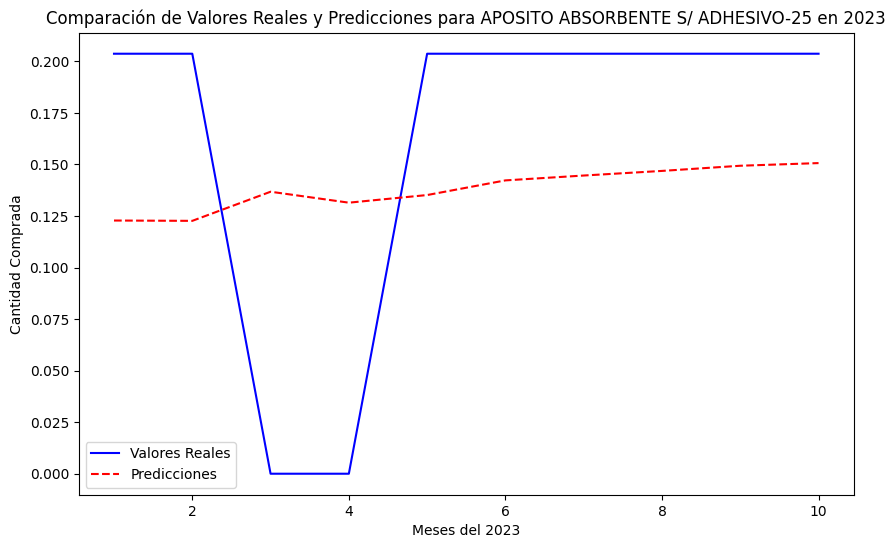

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


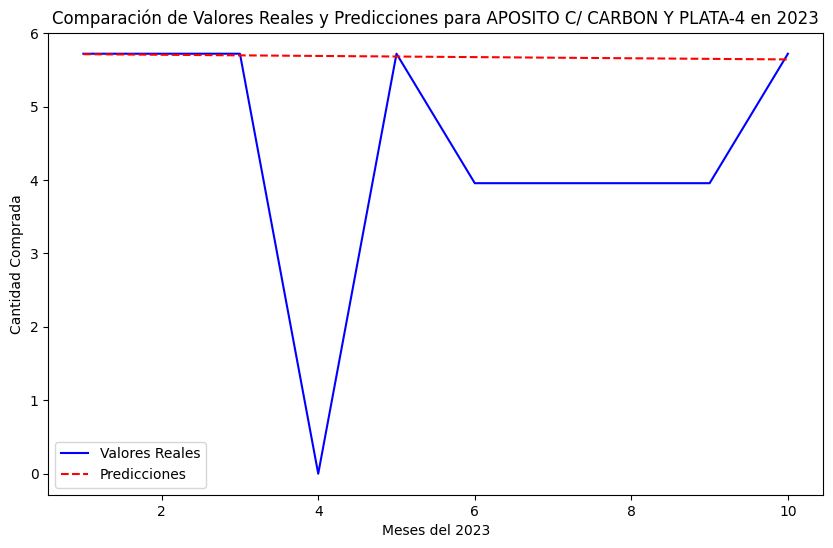

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


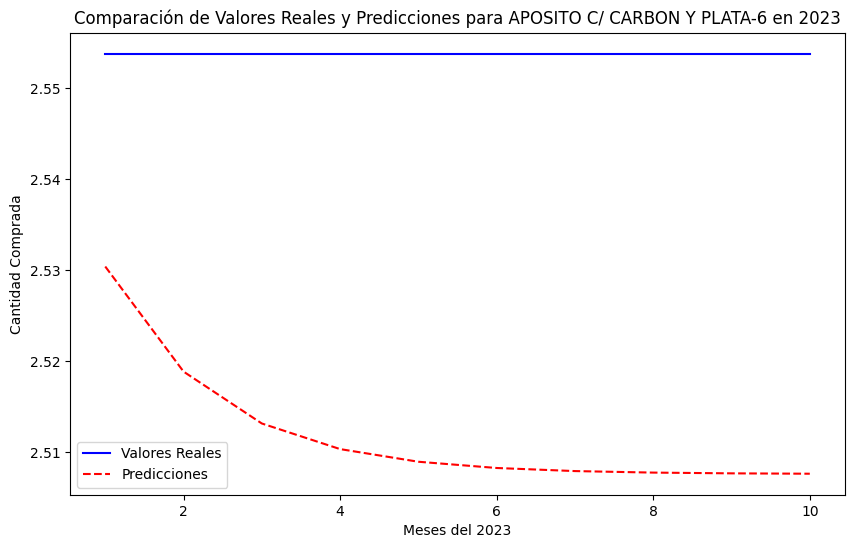

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


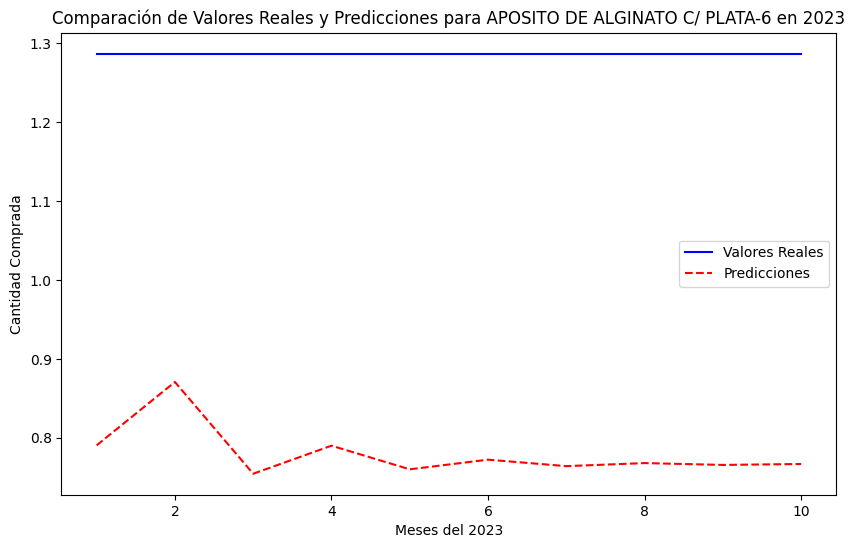

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


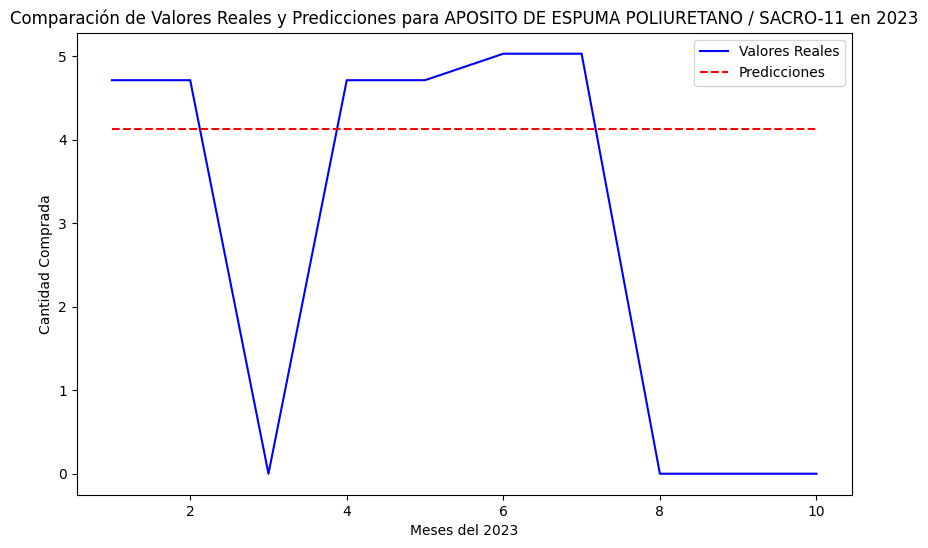

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


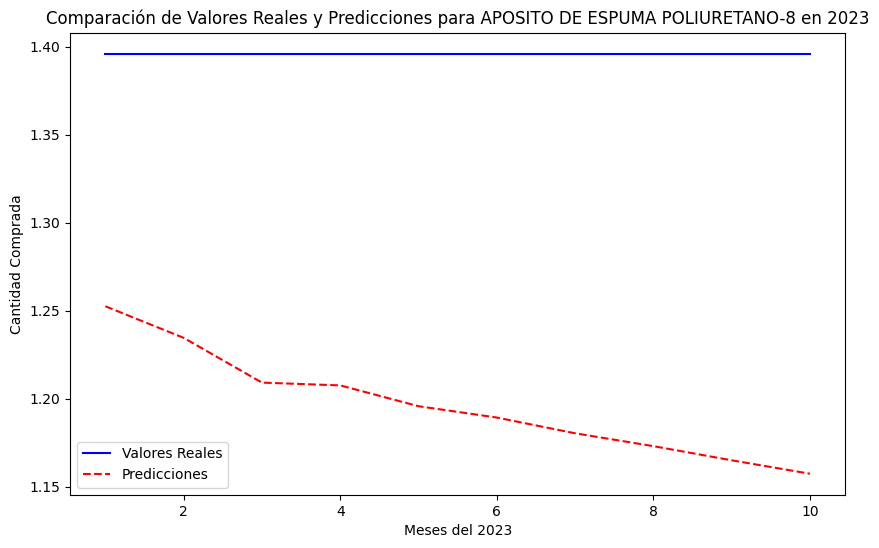

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


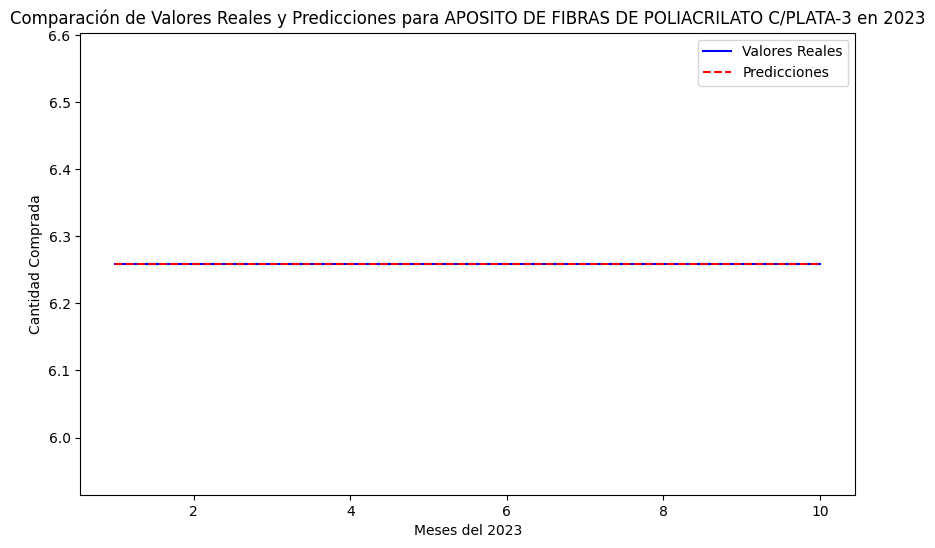

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


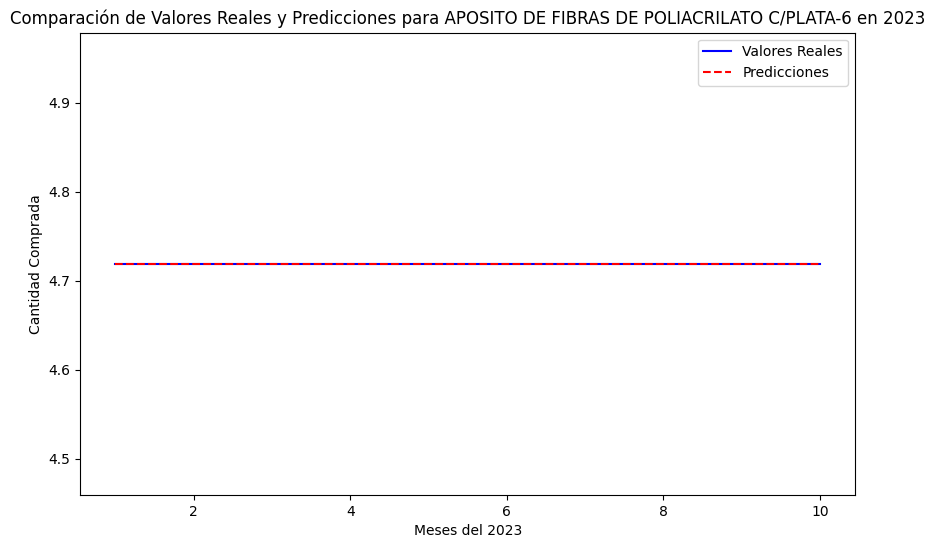

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


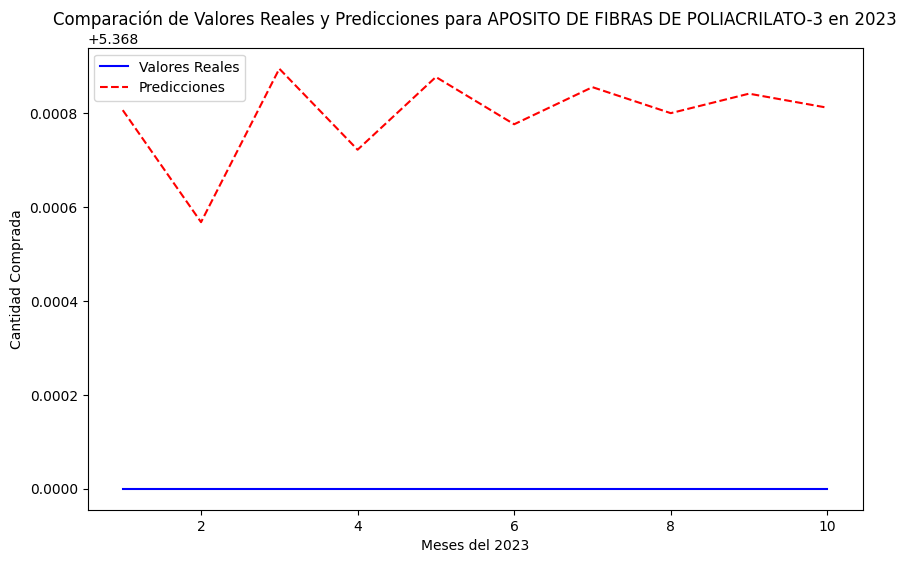

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


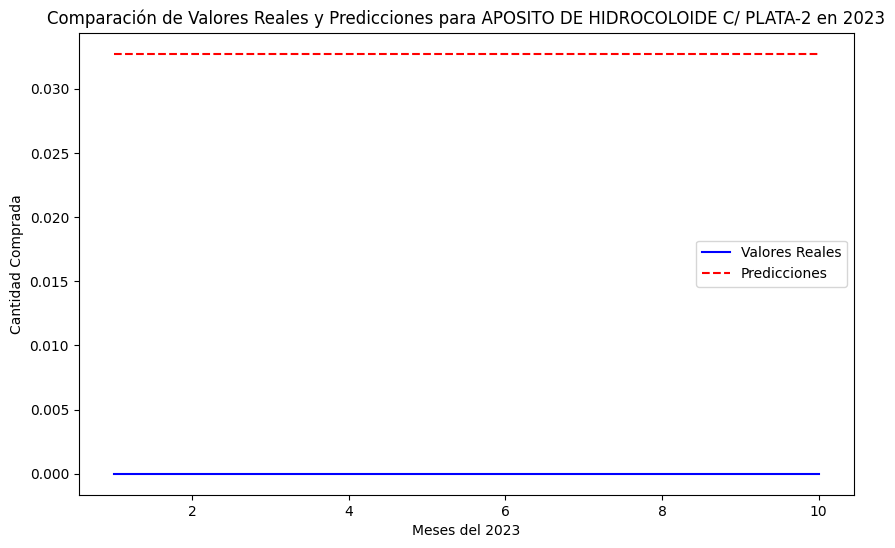

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


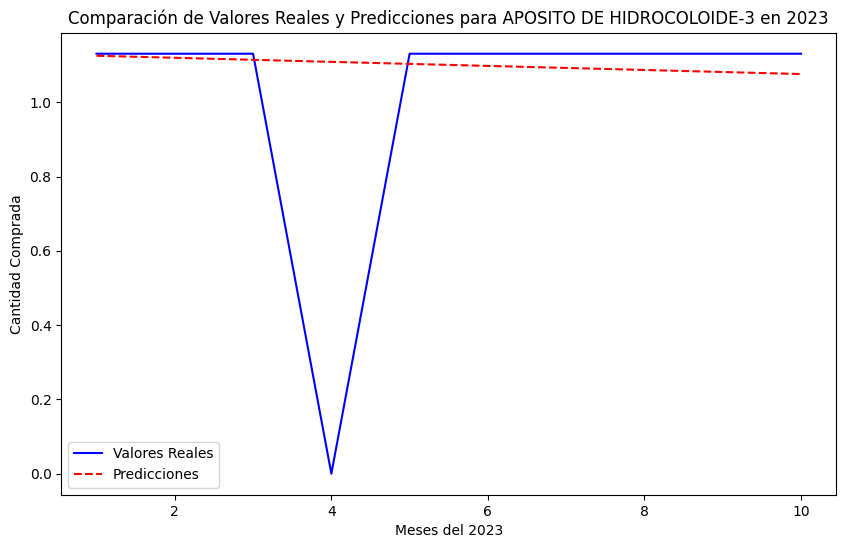

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


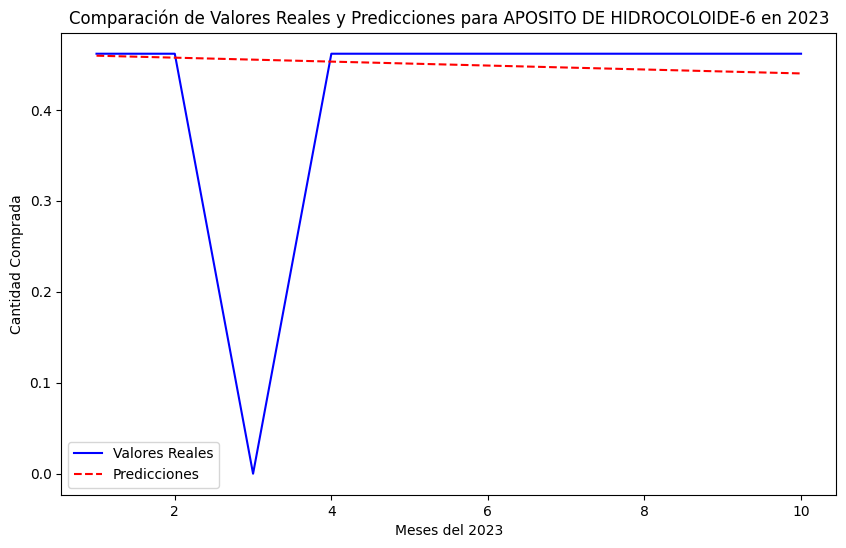

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


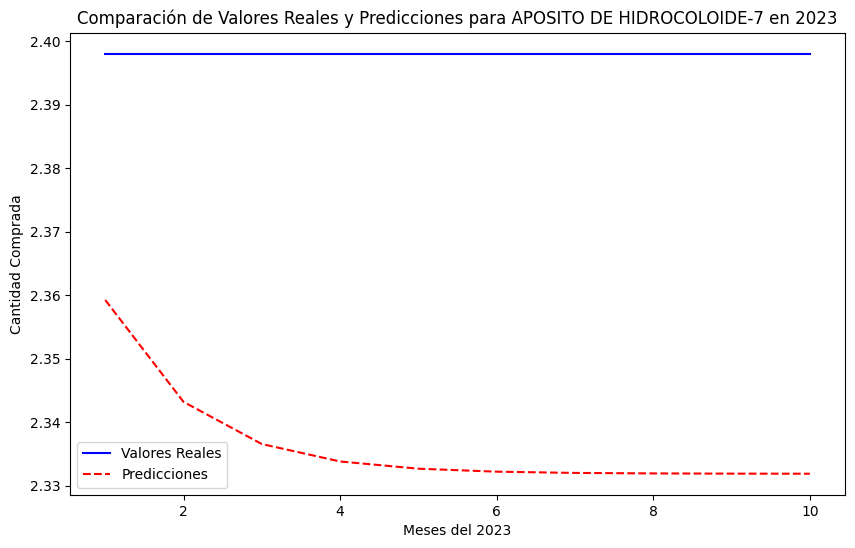

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


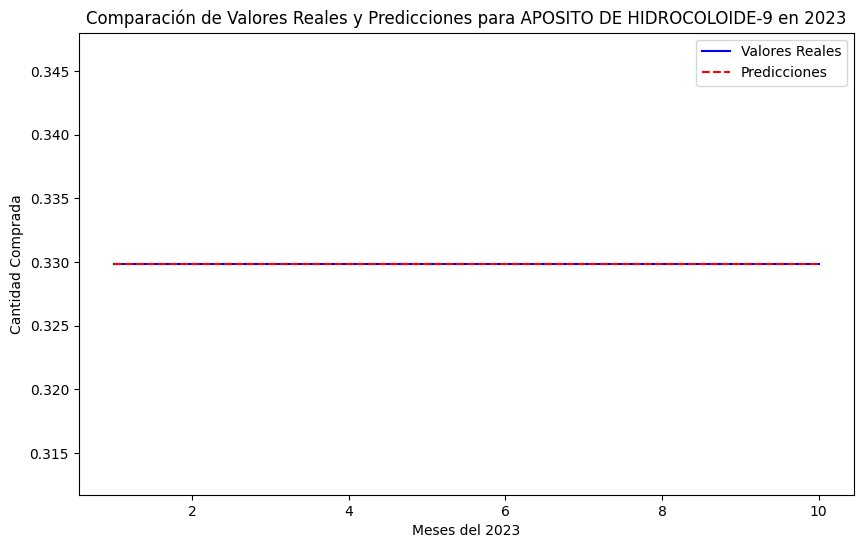

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


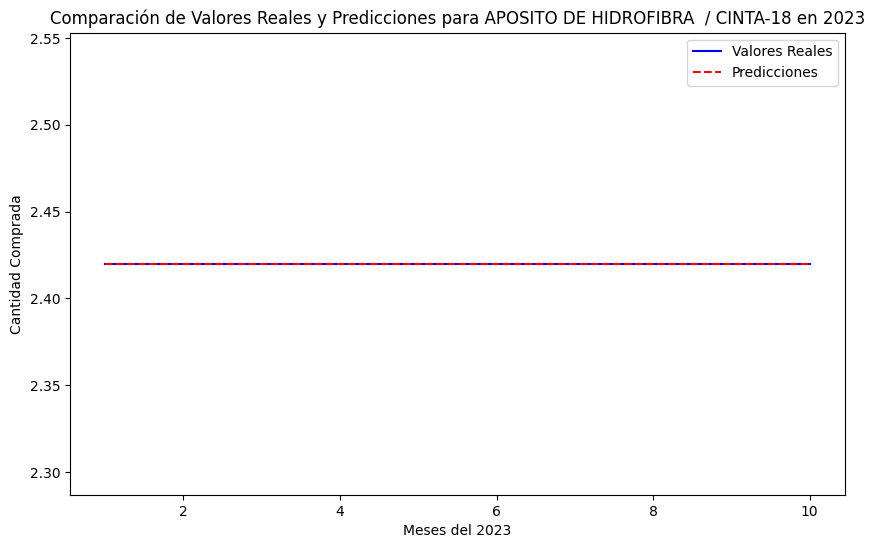

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


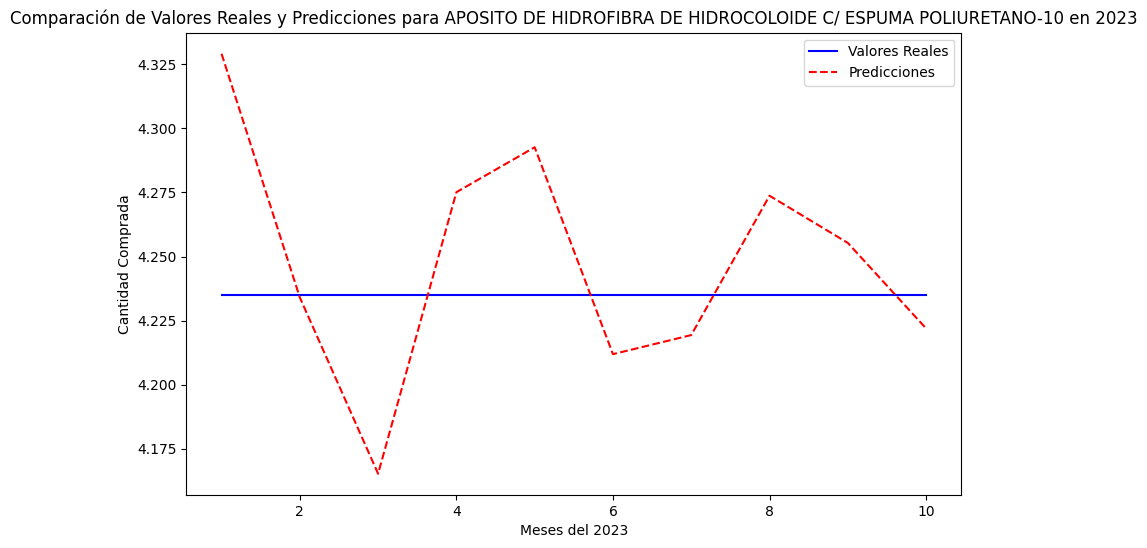

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


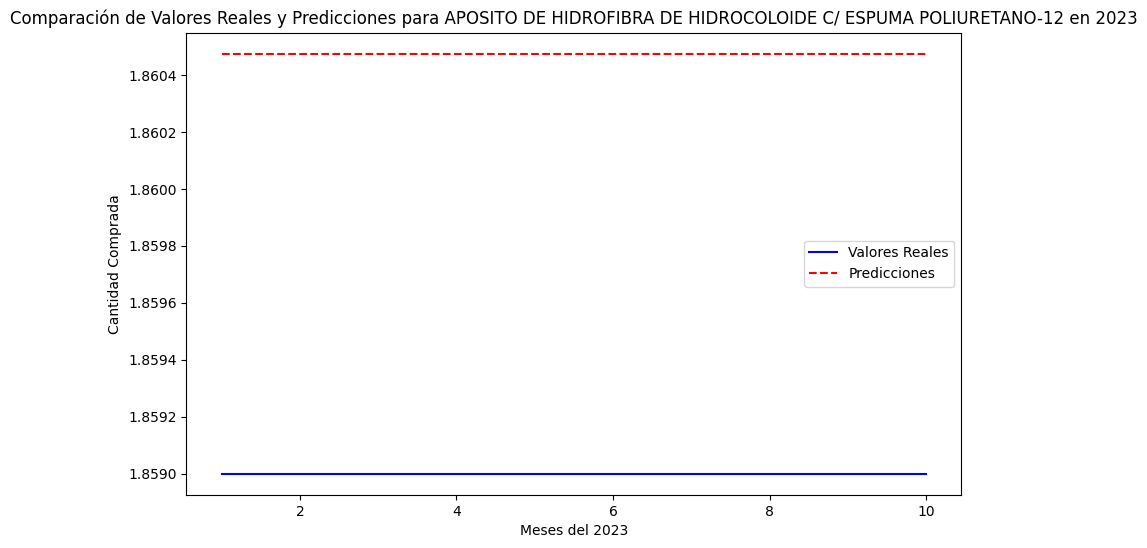

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


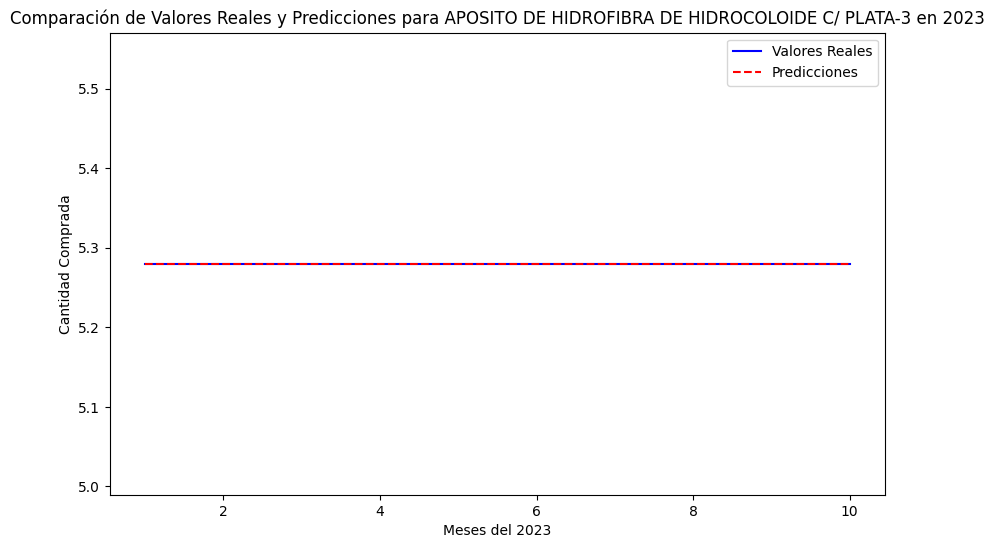

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


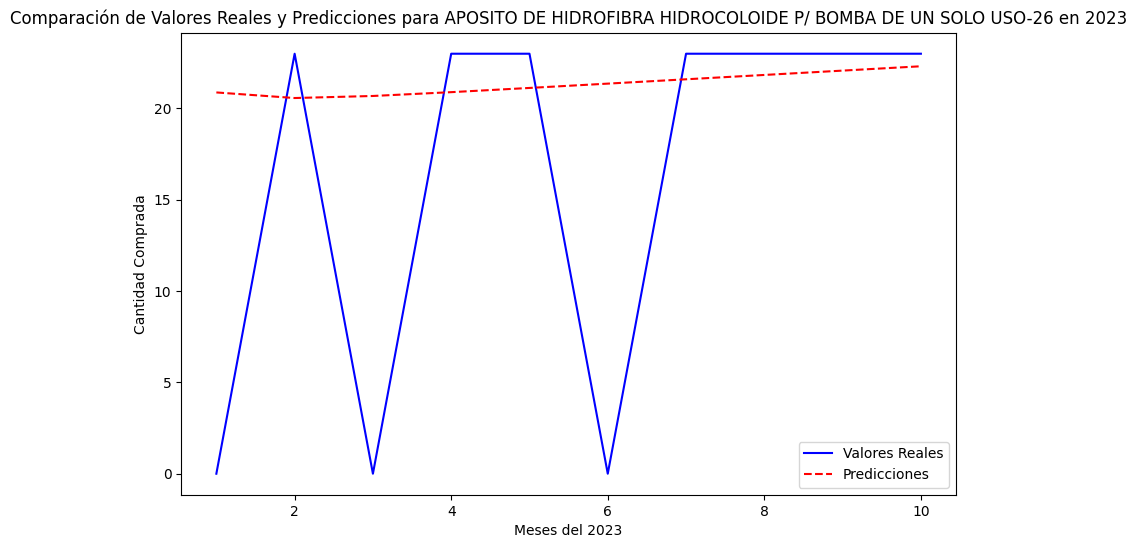

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


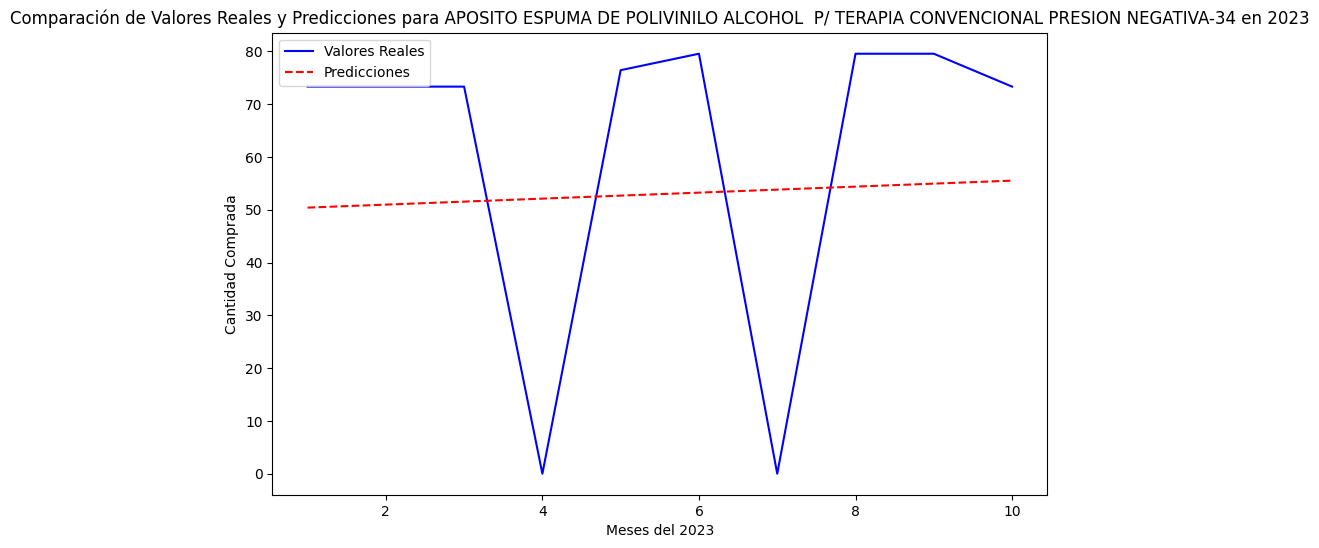

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


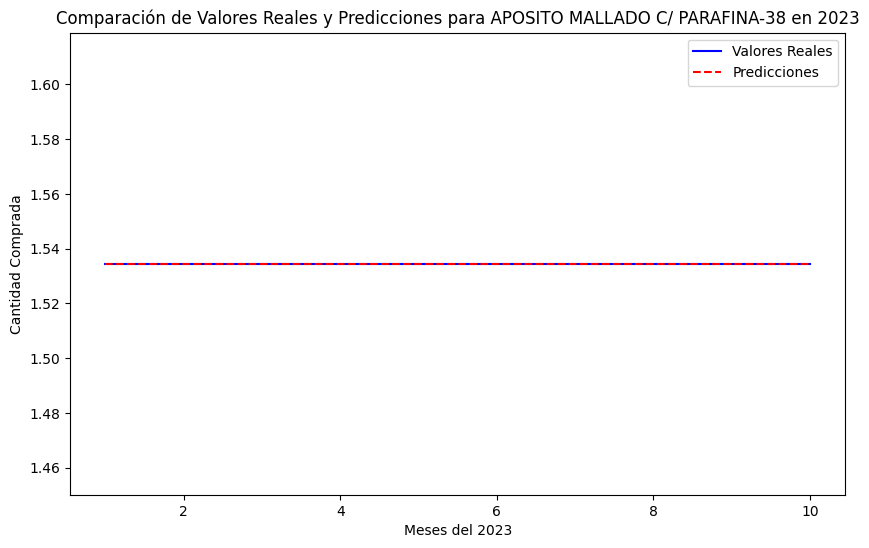

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


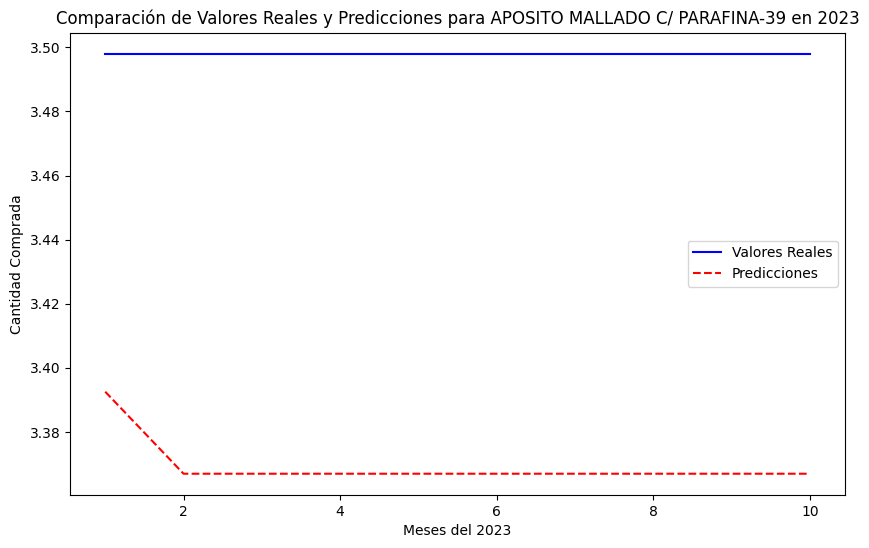

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


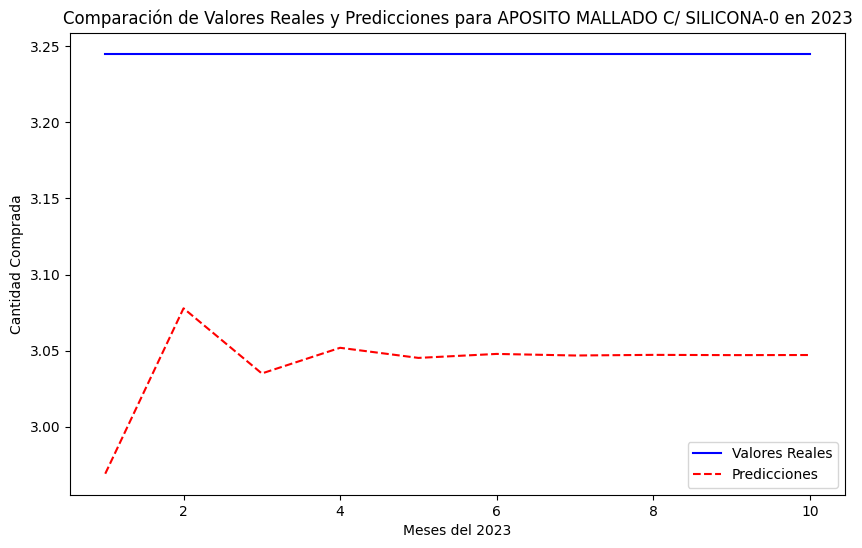

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


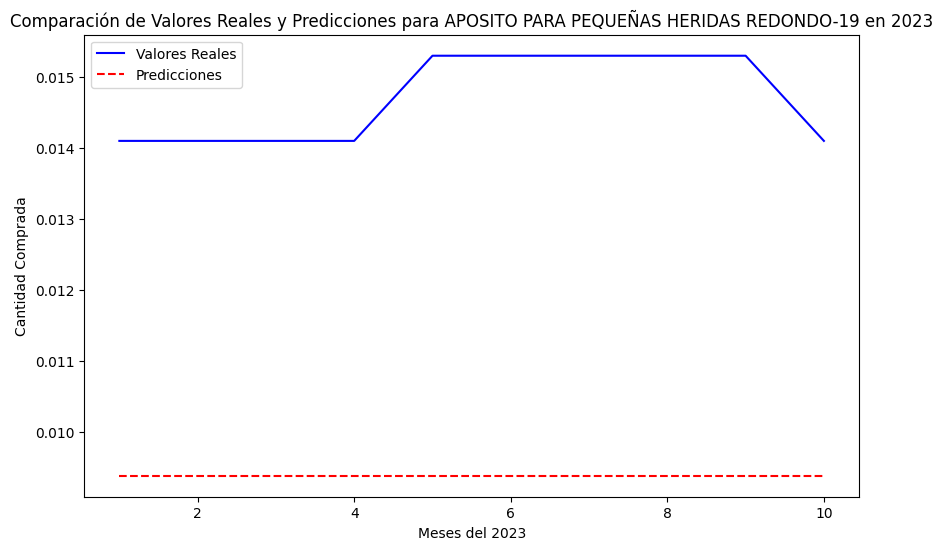

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


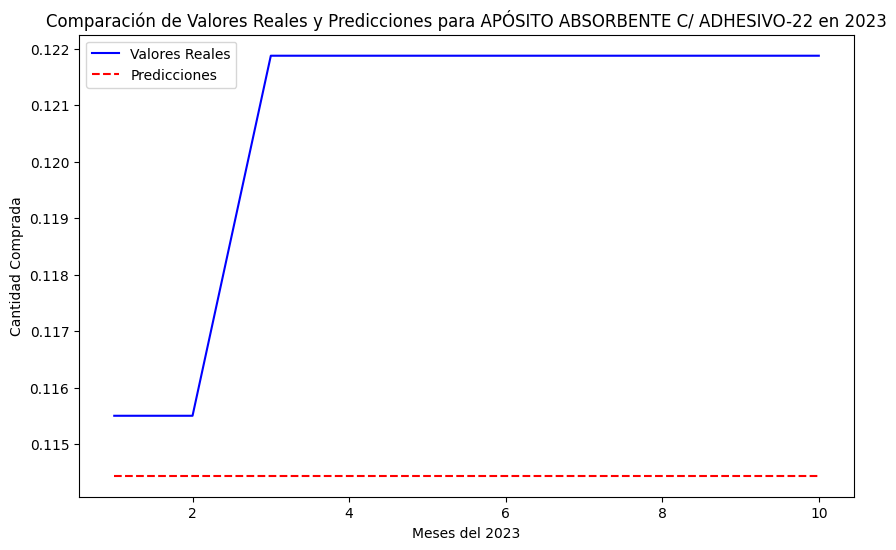

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


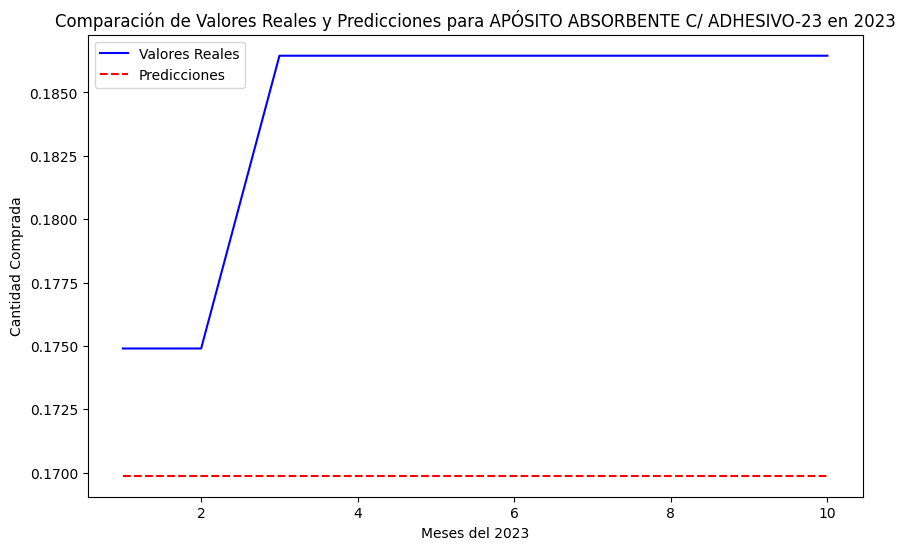

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


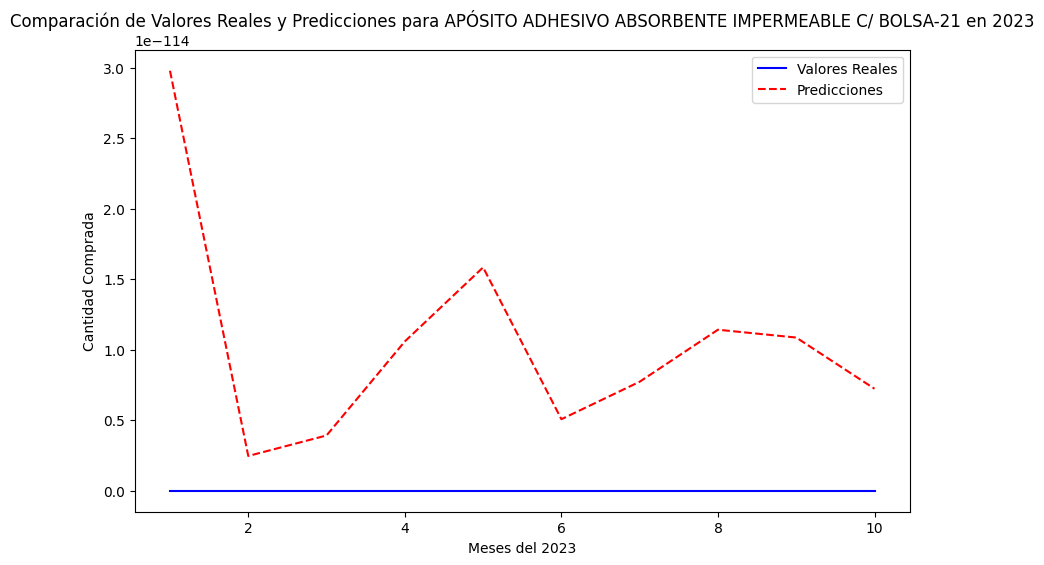

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


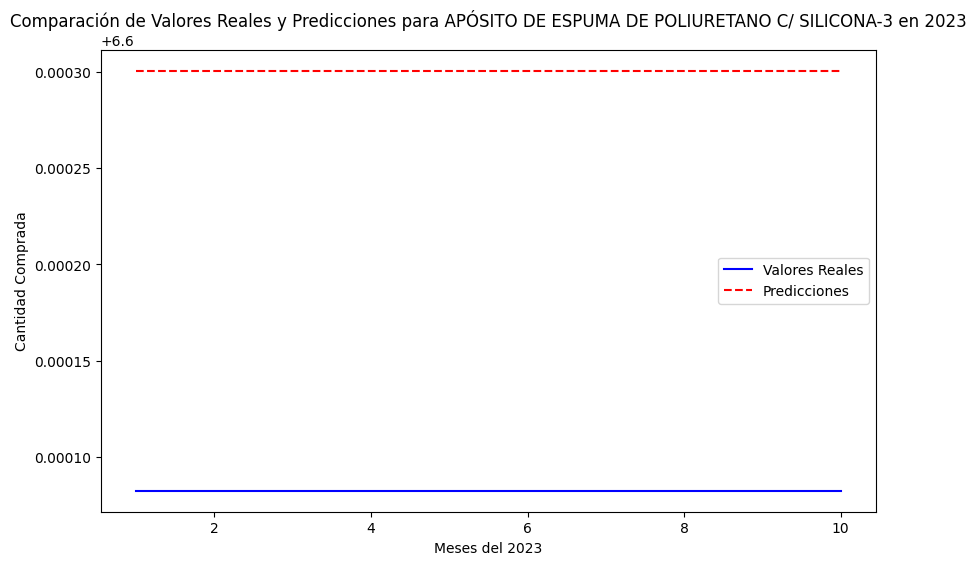

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


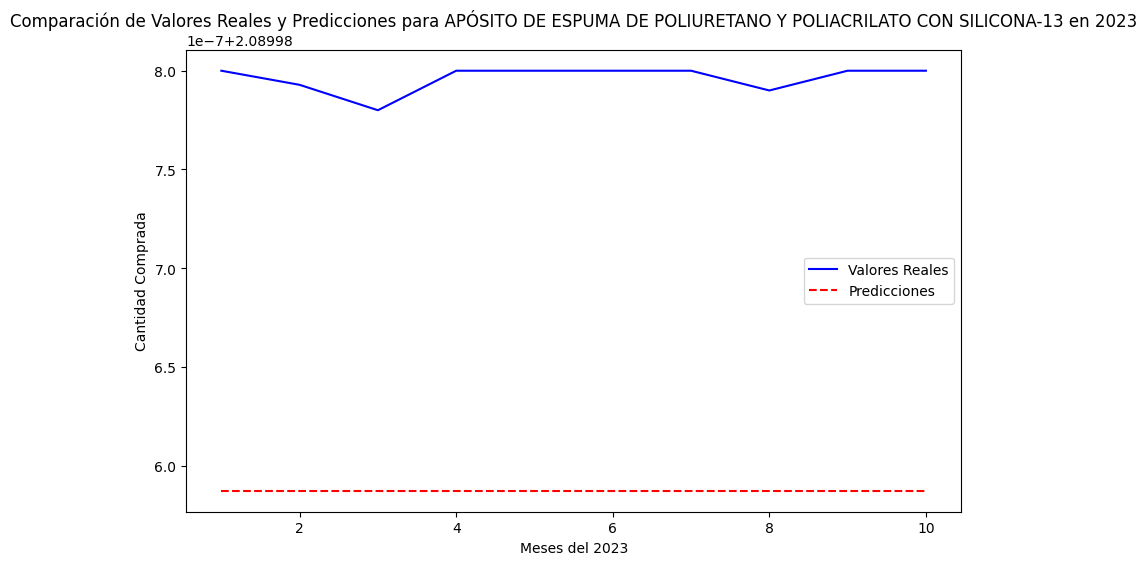

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


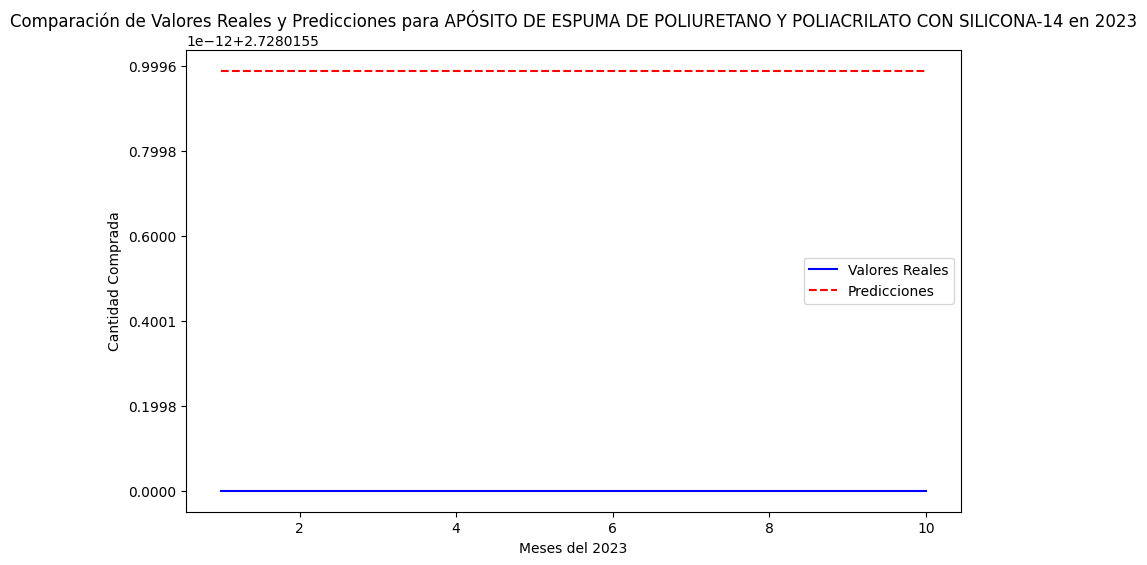

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


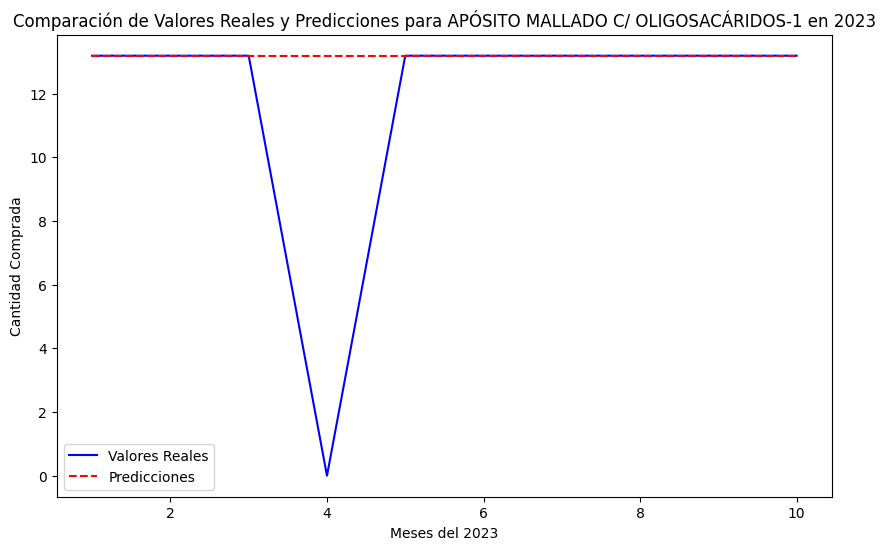

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


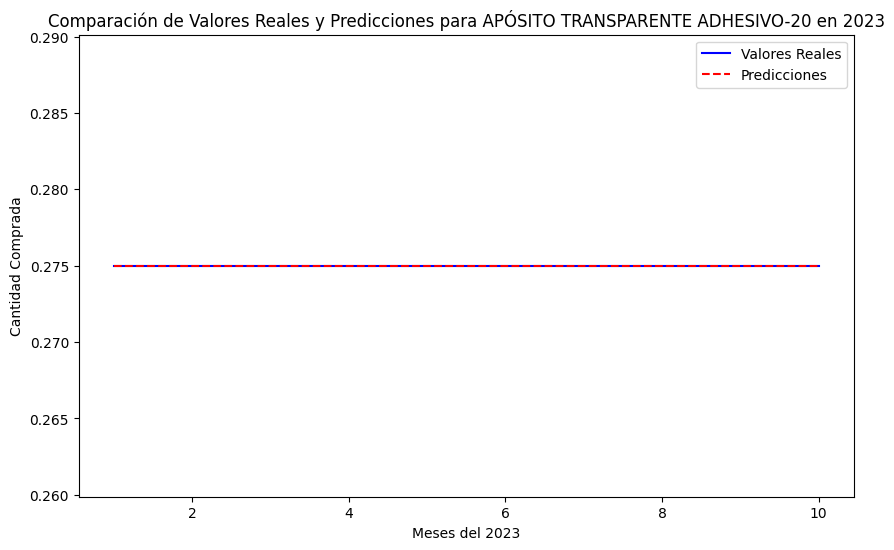

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


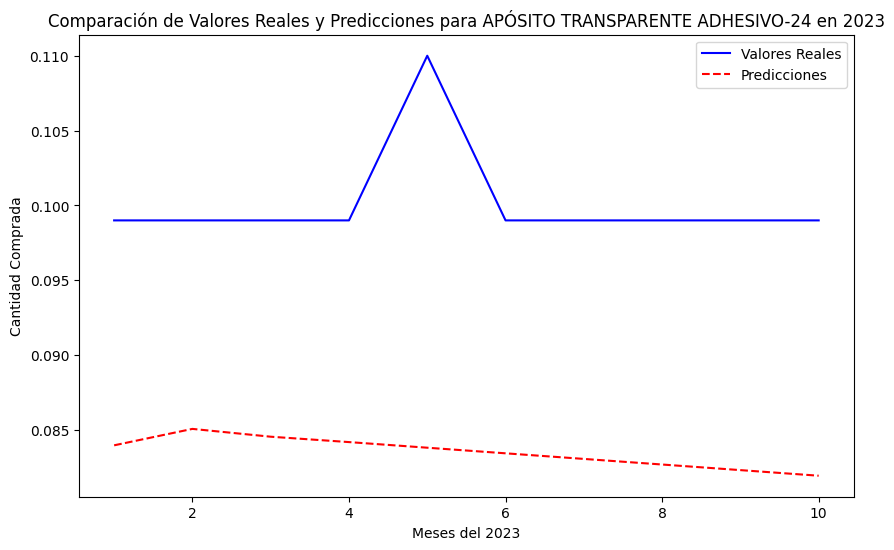

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


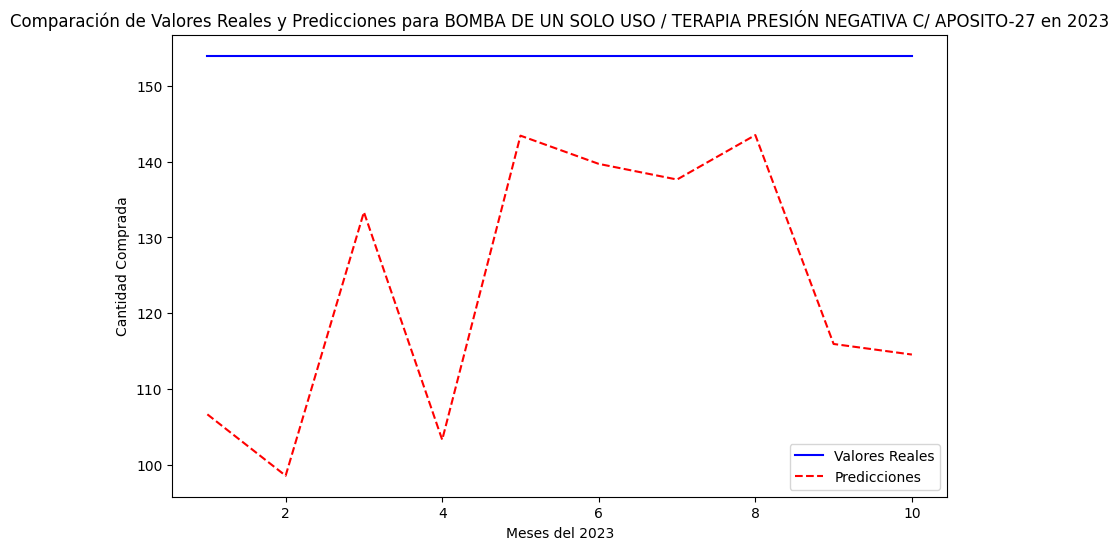

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


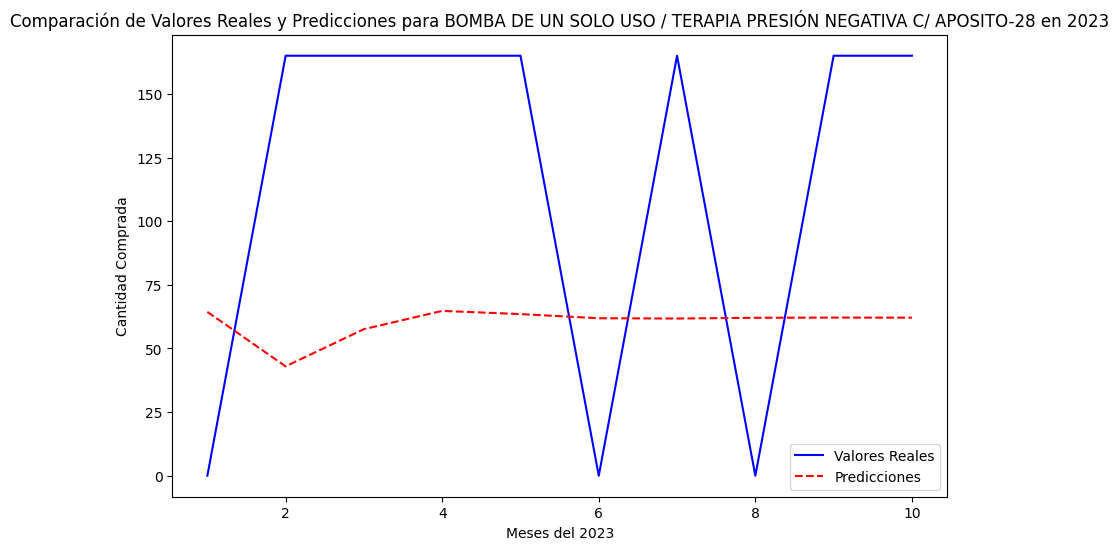

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


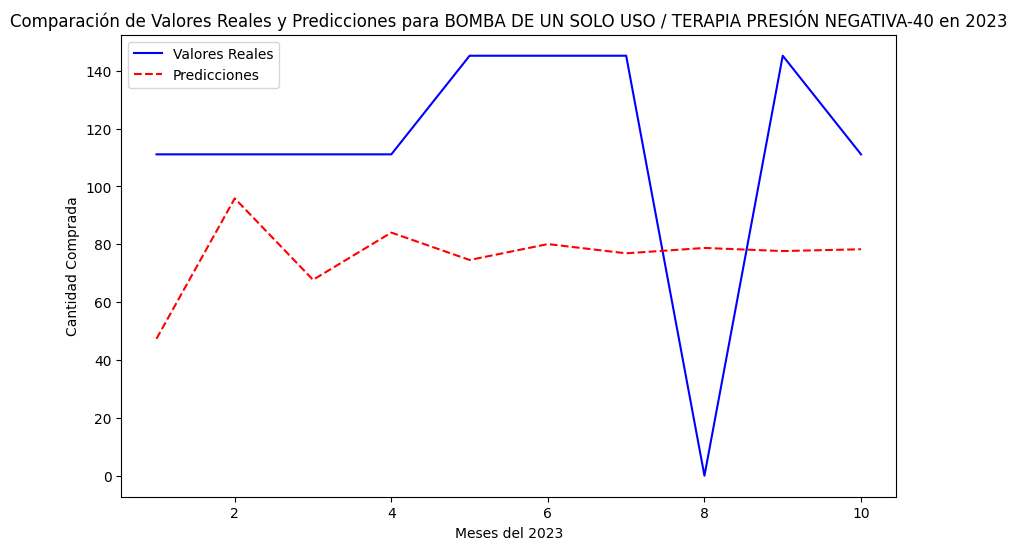

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


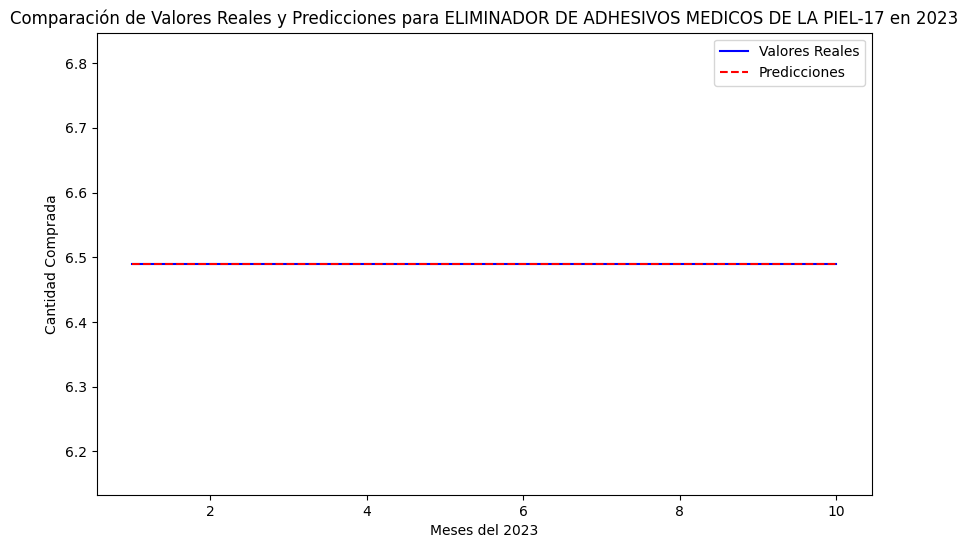

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


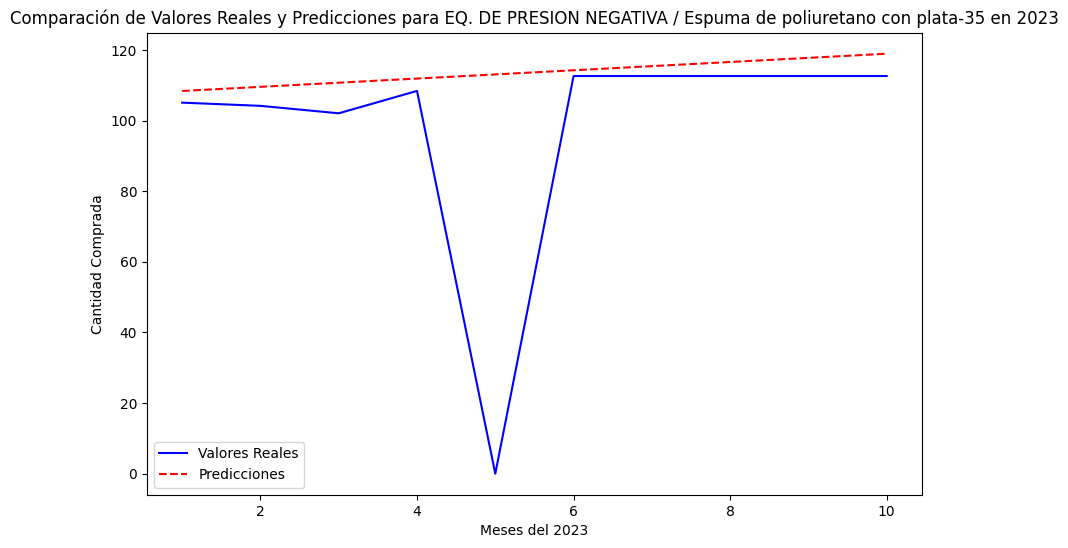

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


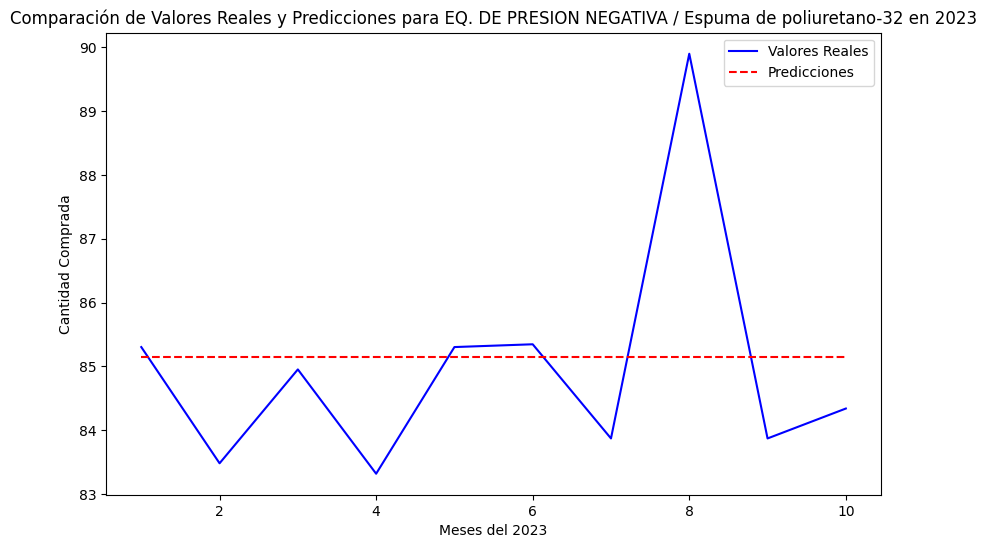

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


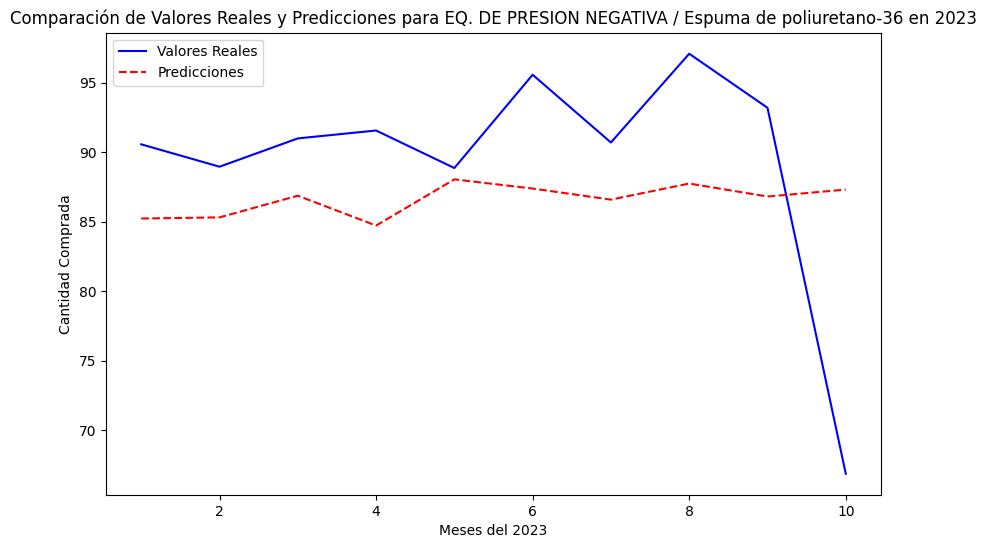

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


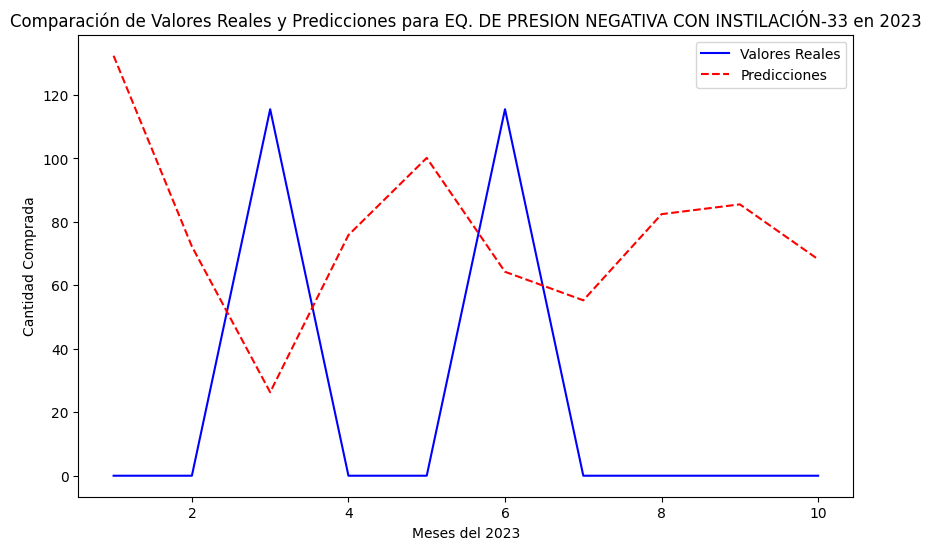

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


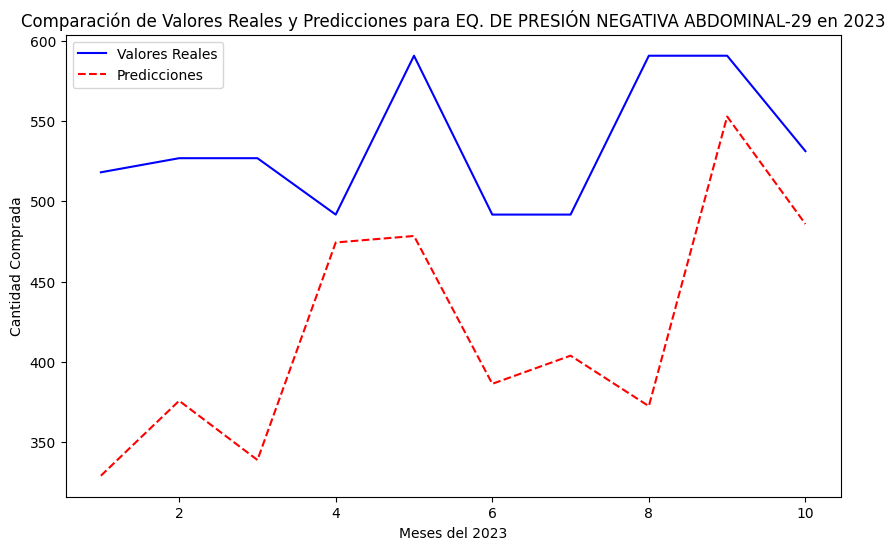

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


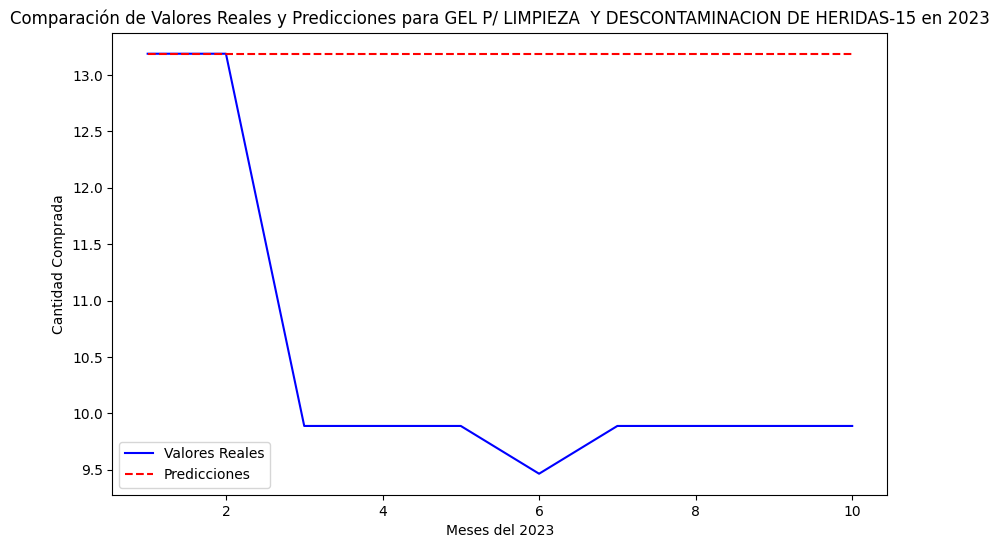

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


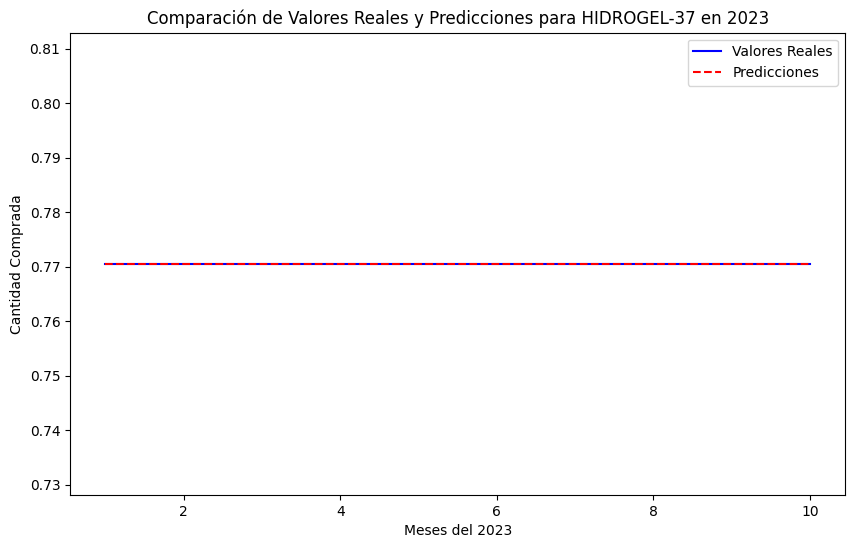

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


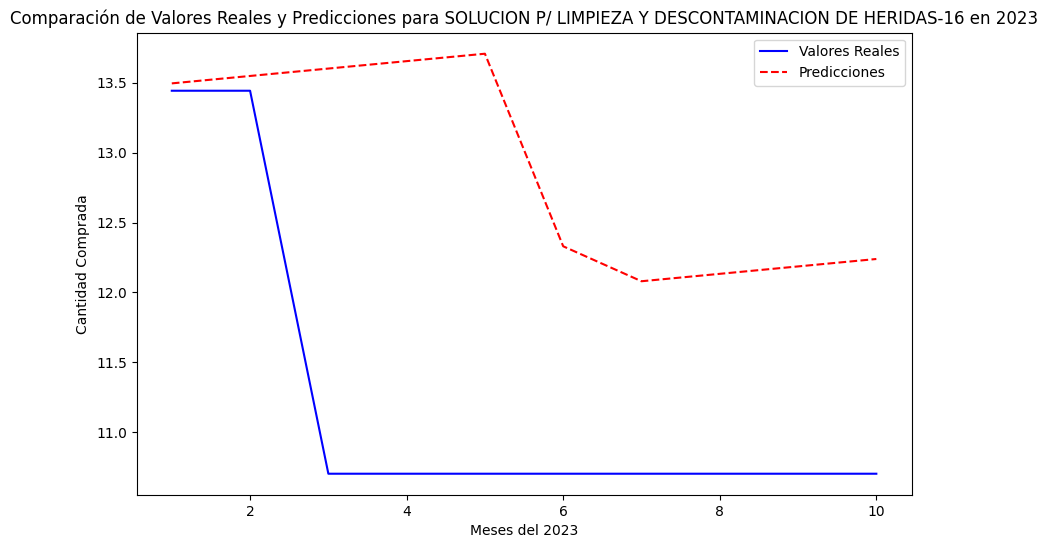

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


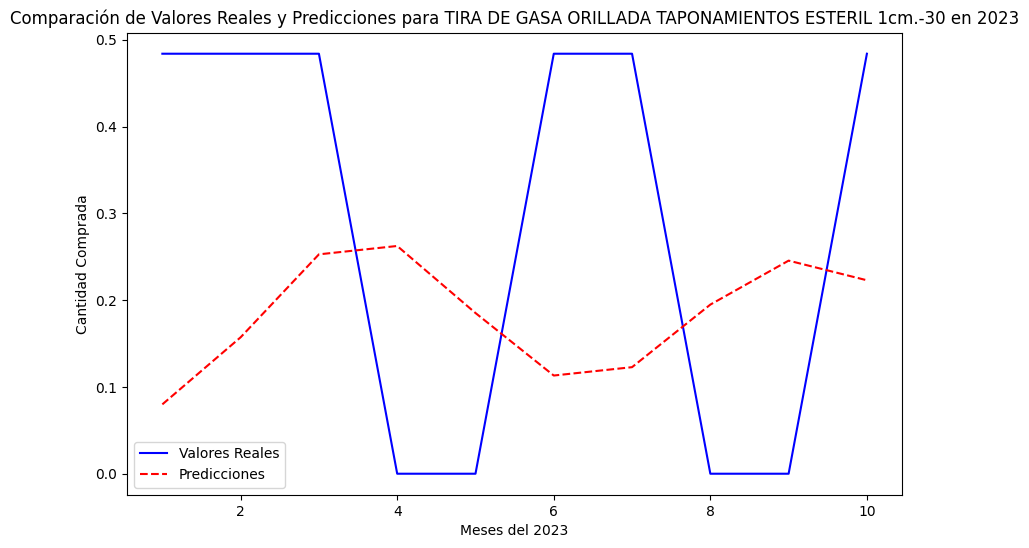

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\737632917.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


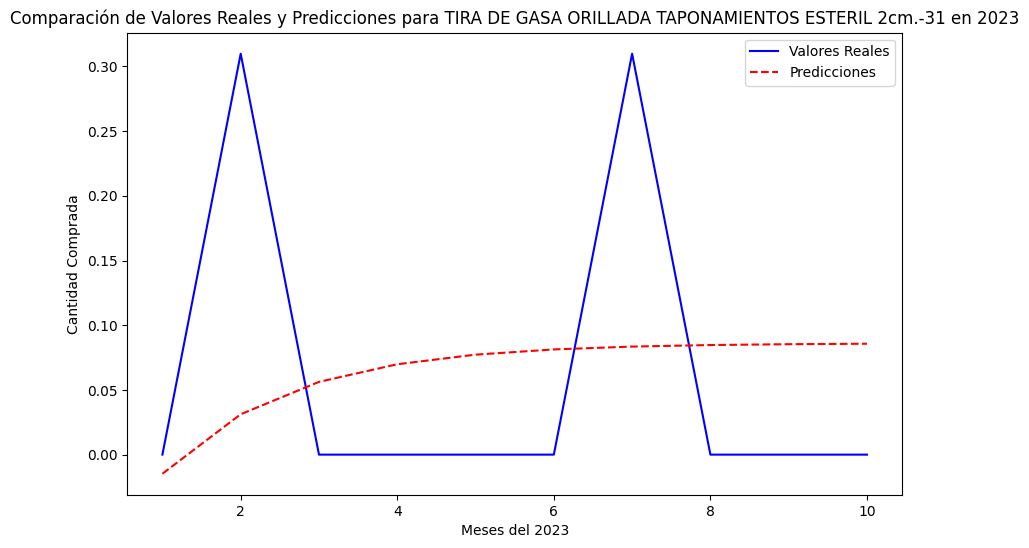

R^2 general: 0.8796722496378839


In [8]:
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# Carga de datos
data = pd.read_csv('../assets/preciounidad_combinations.csv')

# Agrupación de datos por producto y mes
grouped_data = data.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'PRECIOUNIDAD': 'mean'}).reset_index()

# Inicializar un diccionario para almacenar los modelos
models = {}

# Función para verificar la estacionariedad
def check_stationarity(ts):
    return ndiffs(ts, test='adf') > 0

# Iterar sobre cada producto
for product_name in grouped_data['PRODUCTO'].unique():
    product_data = grouped_data[grouped_data['PRODUCTO'] == product_name].copy()

    # Crear un índice de tiempo combinando año y mes
    product_data.loc[:, 'Fecha'] = pd.to_datetime(product_data['AÑO'].astype(str) + '-' + product_data['MES'].astype(str)) + MonthEnd(1)
    product_series = product_data.set_index('Fecha')['PRECIOUNIDAD']

    # Dividir en conjunto de entrenamiento y prueba
    train = product_series[:'2022-12-31']
    test = product_series['2023-01-31':'2023-10-31']

    try:
        # Aplicar Auto ARIMA
        stationarity = check_stationarity(train)
        model = auto_arima(train, seasonal=stationarity, m=12 if stationarity else 0, trace=True, error_action='ignore', suppress_warnings=True)
        models[product_name] = model
    except Exception as e:
        print(f"Error al modelar el producto {product_name}: {e}")

# Preparar los datos de prueba y alinearlos con las predicciones
test_data = data[(data['AÑO'] == 2023) & (data['MES'] <= 10)].copy()

# Realizar predicciones y comparar con los datos de prueba
for product_name, model in models.items():
    if product_name in grouped_data['PRODUCTO'].unique():
        # Realizar la predicción
        forecast = model.predict(n_periods=10)

        # Insertar predicciones en test_data
        for i, month in enumerate(range(1, 11)):
            test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]

        # Extraer valores reales para el gráfico
        actual_values = test_data[(test_data['PRODUCTO'] == product_name) & (test_data['AÑO'] == 2023) & (test_data['MES'] <= 10)]['PRECIOUNIDAD']

        # Gráfico de las predicciones para cada producto
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, 11), actual_values, label='Valores Reales', color='blue')
        plt.plot(range(1, 11), forecast, label='Predicciones', color='red', linestyle='--')
        plt.title(f'Comparación de Valores Reales y Predicciones para {product_name} en 2023')
        plt.xlabel('Meses del 2023')
        plt.ylabel('Cantidad Comprada')
        plt.legend()
        plt.show()

from sklearn.metrics import r2_score

# Preparar listas para almacenar todos los valores reales y predichos
all_actual_values = []
all_predicted_values = []

for product_name in grouped_data['PRODUCTO'].unique():
    if product_name in test_data['PRODUCTO'].unique():
        actual_values = test_data[(test_data['PRODUCTO'] == product_name) & (test_data['AÑO'] == 2023) & (test_data['MES'] <= 10)]['PRECIOUNIDAD']
        predicted_values = test_data[(test_data['PRODUCTO'] == product_name) & (test_data['AÑO'] == 2023) & (test_data['MES'] <= 10)]['predicted']

        # Añadir valores reales y predichos a las listas generales
        all_actual_values.extend(actual_values)
        all_predicted_values.extend(predicted_values)

# Calcular R^2 para todos los productos en conjunto
r2_general = r2_score(all_actual_values, all_predicted_values)
print(f"R^2 general: {r2_general}")


# Guardar el conjunto de datos de prueba con las predicciones en un archivo CSV
test_data.to_csv('../assets/preciounidad_predicted.csv', index=False)

Comprovamos las correlaciones entre los valores originales y los predecidos

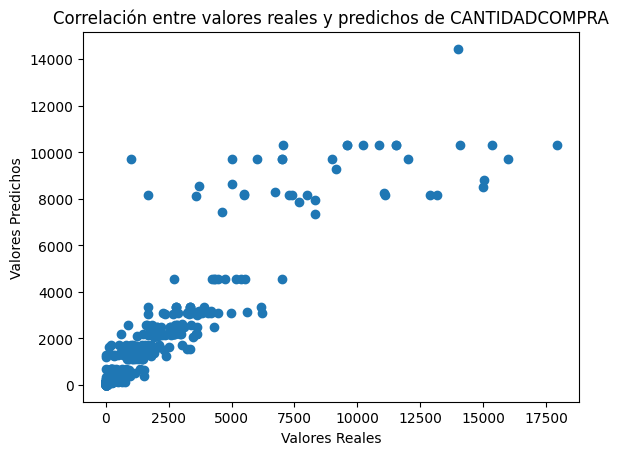

In [9]:
# Load the predicted data
predicted_data_1 = pd.read_csv('../assets/cantidadcompra_predicted.csv')

# Create a scatter plot of predicted vs actual values
plt.scatter(predicted_data_1['CANTIDADCOMPRA'], predicted_data_1['predicted'])
plt.title('Correlación entre valores reales y predichos de CANTIDADCOMPRA')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.show()


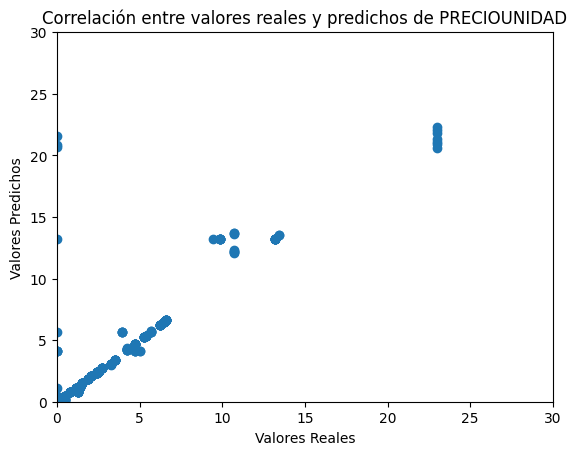

In [10]:
# Load the predicted data
predicted_data_2 = pd.read_csv('../assets/preciounidad_predicted.csv')

# Create a scatter plot of predicted vs actual values
plt.scatter(predicted_data_2['PRECIOUNIDAD'], predicted_data_2['predicted'])
plt.title('Correlación entre valores reales y predichos de PRECIOUNIDAD')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Set limits on the x and y axis to avoid representing outliers
plt.xlim(0, 30)
plt.ylim(0, 30)

plt.show()


Merge results to a final dataset

In [11]:
predicted_partial_2023 = pd.read_csv('../assets/cantidadcompra_predicted.csv')
predicted_partial_2023 = predicted_partial_2023[['AÑO', 'MES', 'PRODUCTO', 'predicted']]
predicted_partial_2023 = predicted_partial_2023.rename(columns={'predicted': 'PREDICTED_CANTIDADCOMPRA'})

predicted_preciounidad = pd.read_csv('../assets/preciounidad_predicted.csv')
predicted_partial_2023['PREDICTED_PRECIOUNIDAD'] = predicted_preciounidad['predicted']

predicted_partial_2023['PREDICTED_IMPORTELINEA'] = predicted_partial_2023['PREDICTED_CANTIDADCOMPRA'] * predicted_partial_2023['PREDICTED_PRECIOUNIDAD']

predicted_partial_2023.to_csv('../assets/predicted_partial_2023.csv', index=False)

Create the final model to predict CANTIDADCOMPRA and PRECIOUNIDAD for all 2023

In [13]:
predicted_2023 = pd.read_csv('../assets/cantidadcompra_predicted.csv')
predicted_2023 = predicted_partial_2023[['AÑO', 'MES', 'PRODUCTO']]

from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# WE START BY PREDICTING 'CANTIDADCOMPRA' FOR ALL THE MONTHS OF 2023

# Carga de datos
data = pd.read_csv('../assets/cantidadcompra_combinations.csv')

# Agrupación de datos por producto y mes
grouped_data = data.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'CANTIDADCOMPRA': 'sum'}).reset_index()

# Inicializar un diccionario para almacenar los modelos
models = {}

# Función para verificar la estacionariedad

def check_stationarity(ts):
    return ndiffs(ts, test='adf') > 0

# Iterar sobre cada producto
for product_name in grouped_data['PRODUCTO'].unique():
    product_data = grouped_data[grouped_data['PRODUCTO'] == product_name].copy()

    # Crear un índice de tiempo combinando año y mes
    product_data.loc[:, 'Fecha'] = pd.to_datetime(product_data['AÑO'].astype(str) + '-' + product_data['MES'].astype(str)) + MonthEnd(1)
    product_series = product_data.set_index('Fecha')['CANTIDADCOMPRA']

    # Dividir en conjunto de entrenamiento y prueba
    train = product_series[:'2022-12-31']
    test = product_series['2023-01-31':'2023-12-31']

    try:
        # Aplicar Auto ARIMA
        stationarity = check_stationarity(train)
        model = auto_arima(train, seasonal=stationarity, m=12 if stationarity else 0, trace=True, error_action='ignore', suppress_warnings=True)
        models[product_name] = model
    except Exception as e:
        print(f"Error al modelar el producto {product_name}: {e}")

# Preparar los datos de prueba y alinearlos con las predicciones
test_data = data[(data['AÑO'] == 2023)].copy()

# Realizar predicciones y comparar con los datos de prueba
for product_name, model in models.items():
    if product_name in grouped_data['PRODUCTO'].unique():
        # Realizar la predicción
        forecast = model.predict(n_periods=122)

        # Insertar predicciones en test_data
        for i, month in enumerate(range(1, 13)):
            test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]


# Guardar el conjunto de datos de prueba con las predicciones en un archivo CSV
test_data.to_csv('../assets/full_cantidadcompra_predicted.csv', index=False)


# WE PREDICT 'PRECIOUNDAD' FOR ALL THE MONTHS OF THE YEAR


# Carga de datos
data = pd.read_csv('../assets/preciounidad_combinations.csv')

# Agrupación de datos por producto y mes
grouped_data = data.groupby(['AÑO', 'MES', 'PRODUCTO']).agg({'PRECIOUNIDAD': 'mean'}).reset_index()

# Inicializar un diccionario para almacenar los modelos
models = {}

# Iterar sobre cada producto
for product_name in grouped_data['PRODUCTO'].unique():
    product_data = grouped_data[grouped_data['PRODUCTO'] == product_name].copy()

    # Crear un índice de tiempo combinando año y mes
    product_data.loc[:, 'Fecha'] = pd.to_datetime(product_data['AÑO'].astype(str) + '-' + product_data['MES'].astype(str)) + MonthEnd(1)
    product_series = product_data.set_index('Fecha')['PRECIOUNIDAD']

    # Dividir en conjunto de entrenamiento y prueba
    train = product_series[:'2022-12-31']
    test = product_series['2023-01-31':'2023-12-31']

    try:
        # Aplicar Auto ARIMA
        stationarity = check_stationarity(train)
        model = auto_arima(train, seasonal=stationarity, m=12 if stationarity else 0, trace=True, error_action='ignore', suppress_warnings=True)
        models[product_name] = model
    except Exception as e:
        print(f"Error al modelar el producto {product_name}: {e}")

# Preparar los datos de prueba y alinearlos con las predicciones
test_data2 = data[(data['AÑO'] == 2023) & (data['MES'] <= 12)].copy()

# Realizar predicciones y comparar con los datos de prueba
for product_name, model in models.items():
    if product_name in grouped_data['PRODUCTO'].unique():
        # Realizar la predicción
        forecast = model.predict(n_periods=12)

        # Insertar predicciones en test_data
        for i, month in enumerate(range(1, 13)):
            test_data2.loc[(test_data2['PRODUCTO'] == product_name) & (test_data2['MES'] == month), 'predicted'] = forecast[i]

        # Extraer valores reales para el gráfico
        actual_values = test_data2[(test_data2['PRODUCTO'] == product_name) & (test_data2['AÑO'] == 2023)]['PRECIOUNIDAD']


# Preparar listas para almacenar todos los valores reales y predichos
all_predicted_values = []

for product_name in grouped_data['PRODUCTO'].unique():
    if product_name in test_data['PRODUCTO'].unique():
        predicted_values = test_data2[(test_data2['PRODUCTO'] == product_name) & (test_data2['AÑO'] == 2023)]['predicted']




# Guardar el conjunto de datos de prueba con las predicciones en un archivo CSV
test_data2.to_csv('../assets/full_preciounidad_predicted.csv', index=False)

predicted_2023['PREDICTED_PRECIOUNIDAD'] = predicted_preciounidad['predicted']
predicted_2023['PREDICTED_IMPORTELINEA'] = predicted_partial_2023['PREDICTED_CANTIDADCOMPRA'] * predicted_partial_2023['PREDICTED_PRECIOUNIDAD']

predicted_2023.to_csv('../assets/full_predicted_2023.csv', index=False)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1371.759, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1333.348, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1349.208, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1324.607, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1309.283, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1300.768, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1297.862, Time=0.05 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1282.408, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1277.537, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1275.581, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1273.583, T

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\914071354.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]
C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\914071354.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data.loc[(test_data['PRODUCTO'] == product_name) & (test_data['MES'] == month), 'predicted'] = forecast[i]
C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\914071354.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-57.346, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-133.882, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-98.470, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-146.106, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-162.704, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-164.633, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-165.124, Time=0.17 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-177.770, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-188.690, Time=0.28 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-189.897, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-187.279, Tim

C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\914071354.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data2.loc[(test_data2['PRODUCTO'] == product_name) & (test_data2['MES'] == month), 'predicted'] = forecast[i]
C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\914071354.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_data2.loc[(test_data2['PRODUCTO'] == product_name) & (test_data2['MES'] == month), 'predicted'] = forecast[i]
C:\Users\Cai Selvas Sala\AppData\Local\Temp\ipykernel_20660\914071354.py:106: FutureWarning: Series.__getitem__ treating keys as positions is depr